In [2]:
# system setting
import os
import sys
file_path = globals()['_dh'][0]
root_dir = os.path.abspath(os.path.join(file_path, '../../..'))
sys.path.append(root_dir)
sys.dont_write_bytecode = True
os.chdir(root_dir)


print(f"Current working directory: {root_dir}")

import pandas as pd
from tqdm import tqdm   
import numpy as np
import seaborn as sns
# roc curve
from sklearn.metrics import roc_curve, roc_auc_score
# import warnings
import warnings

Current working directory: /Users/zhounan/Documents/Github_Project/BioForce


In [4]:
from A01_RIF.utils.func import *

# Preproceesing

In [ ]:
# 

In [3]:
data = pd.read_csv('data/data_processed/RIF_n311_m40599_0817.csv')
index_start = data.columns.get_loc('TSPAN6')

In [4]:
data = pd.read_csv('RIF/data/RIF_testify_398_已经log2plus1.csv', index_col=0)

In [5]:
# rename '日期差值' to interval_from_ert_to_transfer
# rename 基础内分泌AMH to AMH
# drop  '基础内分泌FSH', '基础内分泌E2','基础内分泌LH'
# data.rename(columns={'日期差值':'interval_from_ert_to_transfer'}, inplace=True)
data.drop(['基础内分泌FSH', '基础内分泌E2','基础内分泌LH','基础内分泌AMH'], axis=1, inplace=True)

data.drop(['day_of_embryo'], axis=1, inplace=True)

# rename '移植胚胎评价' to embryo_evaluation
# data.rename(columns={'移植胚胎评价':'embryo_evaluation'}, inplace=True)

# drop  '基础内分泌FSH', '基础内分泌E2', '基础内分泌LH', '基础内分泌AMH',
# data.drop(['基础内分泌FSH', '基础内分泌E2', '基础内分泌LH', '基础内分泌AMH'], axis=1, inplace=True)

In [6]:
embryo_evaluation = list(data['移植胚胎评价'])

for i in range(len(embryo_evaluation)):
    tmp = embryo_evaluation[i]
    
    # if tmp is X月Y日, change to Y/X
    if '月' in tmp and '日' in tmp:
        month = tmp.split('月')[0]
        day = tmp.split('月')[1].split('日')[0]
        embryo_evaluation[i] = f'{day}/{month}'
        
    if ',' in tmp:
        embryo_evaluation[i] = tmp.split(',')
    
    if '，' in tmp:
        embryo_evaluation[i] = tmp.split('，')
        
    if ' ' in tmp:
        # '  ' to ' '
        # '   ' to ' '
        # '    ' to ' '
        tmp = tmp.replace('  ', ' ')
        tmp = tmp.replace('   ', ' ')
        tmp = tmp.replace('    ', ' ')
        
        embryo_evaluation[i] = tmp.split(' ')
        
for i in range(len(embryo_evaluation)):
    if type(embryo_evaluation[i]) != list:
        embryo_evaluation[i] = [embryo_evaluation[i]]
        
    else:
        tmp = embryo_evaluation[i]
        
        for j in range(len(tmp)):
            if tmp[j] == '':
                tmp.pop(j)
                break
        embryo_evaluation[i] = tmp
        
data['embryo_evaluation_modified'] = embryo_evaluation
        
# 4AA、4BB、4AB、4BA if appears, add 0.2 to the score. Appears 2 times add 0.2 still. 
score_list = [0] * len(data)
for i in range(len(data)):
    embryo_evaluation = data['embryo_evaluation_modified'].iloc[i]
    
    # any element in embryo_evaluation is 4AA, 4BB, 4AB, 4BA, add 0.2 to the score
    add = 0
    for item in embryo_evaluation:
        if item == '4AA' or item == '4BB' or item == '4AB' or item == '4BA' \
            or '5AA' or item == '5BB' or item == '5AB' or item == '5BA' \
            or item == '6AA' or item == '6BB' or item == '6AB' or item == '6BA' \
            or item == '11/7' or item == '12/7' or item == '21/7'\
            or item == '11/8' or item == '12/8' or item == '21/8'\
            or item == '11/9' or item == '12/9' or item == '21/9':
            add += 0.2
        else:
            add += 0.1 
    
    score_list[i] += add 
    
    # add number of embryo_evaluation_num
    
    score_list[i] += data['num_of_embryo'].iloc[i]
    
data['embryo_evaluation_value'] = score_list

# drop embryo_evaluation and embryo_evaluation_modified
data.drop(['移植胚胎评价', 'embryo_evaluation_modified'], axis=1, inplace=True)
        

In [7]:
data['interval_from_ert_to_transfer'] = data['日期差值']

data.drop(['日期差值'], axis=1, inplace=True)

移植日期 = data['移植日期']

# convert to datetime
移植日期 = pd.to_datetime(移植日期, format='%Y-%m-%d')

检测日期 = data['检测流水号']
检测日期 = 检测日期.str.split('_').str[2]
检测日期 = ['20' + i for i in 检测日期]

# convert to datetime
检测日期 = pd.to_datetime(检测日期, format='%Y%m%d')

data['检测日期'] = 检测日期
data['移植日期'] = 移植日期

target = 'label_1'
n = 35
# save to csv
v = 'v14'
version = 'V14'

In [8]:
data.dropna(inplace=True)
print(f"Number of rows: {data.shape[0]}")

Number of rows: 398


In [9]:
data_0 = data[data[target] == 0]
data_1 = data[data[target] == 1]

# random select n data_0 and data_1 into data_val 
import random
random_seed = random.randint(0, 1000)
data_0_val = data_0.sample(n=n, random_state=random_seed)
data_1_val = data_1.sample(n=n, random_state=random_seed)

In [10]:
data_0 = data[data[target] == 0]
data_1 = data[data[target] == 1]

# random select n data_0 and data_1 into data_val 
import random
random_seed = random.randint(0, 1000)
data_0_val = data_0.sample(n=n, random_state=random_seed)
data_1_val = data_1.sample(n=n, random_state=random_seed)

# # sort by 移植日期 for data_0 and data_1
# data_0 = data_0.sort_values(by='移植日期', ascending=False)
# data_1 = data_1.sort_values(by='移植日期', ascending=False)

# data_0.reset_index(drop=True, inplace=True)
# data_1.reset_index(drop=True, inplace=True)

# get the first n samples for data_0 and data_1
# data_0_val = data_0.iloc[:n]
# data_1_val = data_1.iloc[:n]

# data_0 = data_0.iloc[n:]
# data_1 = data_1.iloc[n:]

# data_0 drop data_0_val
data_0.drop(data_0_val.index, axis=0, inplace=True)
data_1.drop(data_1_val.index, axis=0, inplace=True)

data_val = pd.concat([data_0_val, data_1_val], axis=0)
data_val.reset_index(drop=True, inplace=True)

data = pd.concat([data_0, data_1], axis=0)
data.reset_index(drop=True, inplace=True)

# sort by 移植日期 for data_0 and data_1
data = data.sort_values(by='移植日期', ascending=False)
data_val = data_val.sort_values(by='移植日期', ascending=False)

data.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

# count the number of target in each group
print(data_val[target].value_counts())
print(data[target].value_counts())

# print shape
print(data_val.shape)
print(data.shape)

/var/folders/tx/33p3vvbj575_4t2tg1fd6sy80000gn/T/ipykernel_21612/2554713823.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_0.drop(data_0_val.index, axis=0, inplace=True)
/var/folders/tx/33p3vvbj575_4t2tg1fd6sy80000gn/T/ipykernel_21612/2554713823.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1.drop(data_1_val.index, axis=0, inplace=True)


label_1
0    35
1    35
Name: count, dtype: int64
label_1
0    200
1    128
Name: count, dtype: int64
(70, 40600)
(328, 40600)


In [11]:
# # drop 检测日期
# data.drop(['检测日期'], axis=1, inplace=True)
# data_val.drop(['检测日期'], axis=1, inplace=True)

In [12]:
# target feature
target_list = ['label_1', 'label_2', 'label_3', ]
col_list_drop = ['移植日期',
 '检测流水号',
 '检测结果',
 'KEYCOD',
 'REGCOD',
 '检测日期']
col_list_drop += target_list
col_list_drop.remove(target)
data = data.drop(col_list_drop, axis=1)


In [13]:
# target feature
# 检测结果 == 容受期
# data = data[data['检测结果'] == '容受期']

# drop 检测结果
# data = data.drop(['检测结果'], axis=1)

# clinical feature
clinical_feature = ['BMI', 'AMH','num_of_embryo', 'embryo_evaluation_value'] # 'Age_at_embryo_transfer', 
data_clinical = data[clinical_feature]

# basic info
X = data.drop([target], axis=1)
## data shape
print(f"Data shape: {X.shape}")

# for each col, calculate the least 95% quantile mean value, get rid of the largest 5% value
mean_list = []
for col in tqdm(X.columns):
    mean = X[col].quantile(0.95)
    mean_list.append(mean)
    
# print num of features that mean < 1 
print(f"Num of features that mean < 1: {len([i for i in mean_list if i < 1])}")

# remove the features that mean < 1
# [i for i in mean_list if i >= 1]
X = X[[col for col, mean in zip(X.columns, mean_list) if mean >= 1]]

# Remove constant features
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(X)

sum(sel.get_support())

X = X[X.columns[sel.get_support()]]

print(f"Data shape after VarianceThreshold: {X.shape}")


# Remove quasi-constant features 
sel = VarianceThreshold(threshold=0.05)
sel.fit(X)

sum(sel.get_support())

X = X[X.columns[sel.get_support()]]
print(f"Data shape after quasi-constant features: {X.shape}")

# calculate the correlation with the target
corr = X.corrwith(data[target])
corr = corr.abs().sort_values(ascending=False)

# select features with correlation greater than 0.05
X = X[corr[corr > 0.03].index]

print(f"Data shape after correlation: {X.shape}")


# add clinical feature
# check clinical feature exist or not 
# if not, add it
for col in clinical_feature:
    if col not in X.columns:
        X[col] = data_clinical[col]
        
data = pd.concat([X, data[target]], axis=1)

# convert all columns to float except target 
X = data.drop([target], axis=1)
X = X.astype(float)
data = pd.concat([X, data[target]], axis=1)

print(f"Data shape after adding clinical feature: {data.shape}")

n = 25
if n != 0:
    data_val = data_val.drop(col_list_drop, axis=1)
    data_val = data_val[data.columns]
    data_val = data_val.astype(float)

    print(f"Data validation shape: {data_val.shape}")

Data shape: (328, 40591)


100%|██████████| 40591/40591 [00:05<00:00, 8006.41it/s]


Num of features that mean < 1: 18691
Data shape after VarianceThreshold: (328, 21900)
Data shape after quasi-constant features: (328, 21897)
Data shape after correlation: (328, 13225)
Data shape after adding clinical feature: (328, 13228)


/var/folders/tx/33p3vvbj575_4t2tg1fd6sy80000gn/T/ipykernel_21612/2760794662.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col] = data_clinical[col]
/var/folders/tx/33p3vvbj575_4t2tg1fd6sy80000gn/T/ipykernel_21612/2760794662.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col] = data_clinical[col]


Data validation shape: (70, 13228)


In [14]:
data_val = data_val[data.columns]
data_val = data_val.astype(float)
data = data.astype(float)

In [15]:
# drop all clinical feature 
# data = data.drop(clinical_feature, axis=1)
# data_val = data_val.drop(clinical_feature, axis=1)

In [16]:
data.to_csv(f'RIF/data/processed_data/{v}.csv', index=False)
data_val.to_csv(f'RIF/data/processed_data/{v}_val.csv', index=False)

In [17]:
# RIF/data/processed_data/processed_data_log.json
info_path = 'RIF/data/processed_data/processed_data_log.json'
import json

# open the file
with open(info_path, 'r') as f:
    data_info = json.load(f)
data_info = {}

# v1
data_info['V1'] = {}
data_info['V1']['data_path'] = 'RIF/data/processed_data/v1.csv'
data_info['V1']['target'] = 'label_3'
data_info['V1']['appendix'] = '容受期; label_3; average < 1 cluttered'
data_info['V1']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v1.csv'))
data_info['V1']['val_exist'] = False

# v2
data_info['V2'] = {}
data_info['V2']['data_path'] = 'RIF/data/processed_data/v2.csv'
data_info['V2']['target'] = 'label_3'
data_info['V2']['appendix'] = '容受期+非容受期; label_3; average < 1 cluttered'
data_info['V2']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v2.csv'))
data_info['V2']['val_exist'] = False

# v3
data_info['V3'] = {}
data_info['V3']['data_path'] = 'RIF/data/processed_data/v3.csv'
data_info['V3']['target'] = 'label_3'
data_info['V3']['appendix'] = '容受期+非容受期; label_3; average < 1 uncluttered (outlier)，pre correlation'
data_info['V3']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v3.csv'))
data_info['V3']['val_exist'] = False

# v4
data_info['V4'] = {}
data_info['V4']['data_path'] = 'RIF/data/processed_data/v4.csv'
data_info['V4']['target'] = 'label_3'
data_info['V4']['appendix'] = '容受期+非容受期; label_3; average < 1 uncluttered; no pre correlation'
data_info['V4']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v4.csv'))
data_info['V4']['val_exist'] = False

# v5
data_info['V5'] = {}
data_info['V5']['data_path'] = 'RIF/data/processed_data/v5.csv'
data_info['V5']['target'] = 'label_1'
data_info['V5']['appendix'] = '容受期+非容受期; label_1; average <1， uncluttered; pre correlation'
data_info['V5']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v5.csv'))
data_info['V5']['val_exist'] = False

# v6
data_info['V6'] = {}
data_info['V6']['data_path'] = 'RIF/data/processed_data/v6.csv'
data_info['V6']['target'] = 'label_2'
data_info['V6']['appendix'] = '容受期+非容受期; label_2; average <1， uncluttered; pre correlation'
data_info['V6']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v6.csv'))
data_info['V6']['val_exist'] = False

# v7
data_info['V7'] = {}
data_info['V7']['data_path'] = 'RIF/data/processed_data/v7.csv'
data_info['V7']['target'] = 'label_3'
data_info['V7']['appendix'] = '容受期+非容受期; label_3; average <1， uncluttered; pre correlation'
data_info['V7']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v7.csv'))
data_info['V7']['val_exist'] = False

# v8
data_info['V8'] = {}
data_info['V8']['data_path'] = 'RIF/data/processed_data/v8.csv'
data_info['V8']['target'] = 'label_1'
data_info['V8']['appendix'] = '容受期+非容受期; label_1; average <1， uncluttered; pre correlation + interval_from_ert_to_transfer + validation set n15'
data_info['V8']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v8.csv'))
data_info['V8']['val_exist'] = True
data_info['V8']['val_data_path'] = 'RIF/data/processed_data/v8_val.csv'
data_info['V8']['val_shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v8_val.csv'))

# v9
data_info['V9'] = {}
data_info['V9']['data_path'] = 'RIF/data/processed_data/v9.csv'
data_info['V9']['target'] = 'label_3'
data_info['V9']['appendix'] = '容受期+非容受期; label_3; average <1， uncluttered; pre correlation + interval_from_ert_to_transfer + validation set n15'
data_info['V9']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v9.csv'))
data_info['V9']['val_exist'] = True
data_info['V9']['val_data_path'] = 'RIF/data/processed_data/v9_val.csv'
data_info['V9']['val_shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v9_val.csv'))

# v10
data_info['V10'] = {}
data_info['V10']['data_path'] = 'RIF/data/processed_data/v10.csv'
data_info['V10']['target'] = 'label_1'
data_info['V10']['appendix'] = '容受期+非容受期; label_1; average <1， uncluttered; pre correlation + interval_from_ert_to_transfer + validation set n25'
data_info['V10']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v10.csv'))
data_info['V10']['val_exist'] = True
data_info['V10']['val_data_path'] = 'RIF/data/processed_data/v10_val.csv'
data_info['V10']['val_shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v10_val.csv'))

# v11
data_info['V11'] = {}
data_info['V11']['data_path'] = 'RIF/data/processed_data/v11.csv'
data_info['V11']['target'] = 'label_3'
data_info['V11']['appendix'] = '容受期+非容受期; label_3; average <1， uncluttered; pre correlation + interval_from_ert_to_transfer + validation set n25'
data_info['V11']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v11.csv'))
data_info['V11']['val_exist'] = True
data_info['V11']['val_data_path'] = 'RIF/data/processed_data/v11_val.csv'
data_info['V11']['val_shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v11_val.csv'))

# v12
data_info['V12'] = {}
data_info['V12']['data_path'] = 'RIF/data/processed_data/v12.csv'
data_info['V12']['target'] = 'label_1'
data_info['V12']['appendix'] = '容受期+非容受期; label_1; average <1， uncluttered; pre correlation + interval_from_ert_to_transfer + validation set n25 no clinical feature'
data_info['V12']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v12.csv'))
data_info['V12']['val_exist'] = True
data_info['V12']['val_data_path'] = 'RIF/data/processed_data/v12_val.csv'
data_info['V12']['val_shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v12_val.csv'))

# v13
data_info['V13'] = {}
data_info['V13']['data_path'] = 'RIF/data/processed_data/v13.csv'
data_info['V13']['target'] = 'label_1'
data_info['V13']['appendix'] = '容受期+非容受期; label_1; average <1， uncluttered; pre correlation + interval_from_ert_to_transfer + validation set n25 no clinical feature new root data 400 '
data_info['V13']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v13.csv'))
data_info['V13']['val_exist'] = True
data_info['V13']['val_data_path'] = 'RIF/data/processed_data/v13_val.csv'
data_info['V13']['val_shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v13_val.csv'))

# v14
data_info['V14'] = {}
data_info['V14']['data_path'] = 'RIF/data/processed_data/v14.csv'
data_info['V14']['target'] = 'label_1'
data_info['V14']['appendix'] = '容受期+非容受期; label_1; average <1， uncluttered; pre correlation + interval_from_ert_to_transfer + validation set n25 no clinical feature new root data 500 '
data_info['V14']['shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v14.csv'))
data_info['V14']['val_exist'] = True
data_info['V14']['val_data_path'] = 'RIF/data/processed_data/v14_val.csv'
data_info['V14']['val_shape'] = np.shape(pd.read_csv('RIF/data/processed_data/v14_val.csv'))
                                         
                                         
# save 
with open(info_path, 'w') as f:
    json.dump(data_info, f, indent=4)

In [18]:
data_path = data_info[version]['data_path']
data = pd.read_csv(data_path)
target = data_info[version]['target'] 
shape = data_info[version]['shape'] 

clinical_feature = ['Age_at_embryo_transfer', 'BMI', 'AMH','num_of_embryo', 'embryo_evaluation_value']

# check existence of clinical feature
for feature in clinical_feature:
    if feature not in data.columns:
        print(f"Missing feature: {feature}")
        print(f"Available feature: {data.columns}")

# remove list 
remove_list = []

data = data.drop(columns=remove_list)

# check data_val exist
if data_info[version]['val_exist']:
    data_val_path = data_info[version]['val_data_path']
    data_val = pd.read_csv(data_val_path)
    val_shape = data_info[version]['val_shape'] 
    
    # check existence of clinical feature
    for feature in clinical_feature:
        if feature not in data_val.columns:
            print(f"Missing feature: {feature}")
            print(f"Available feature: {data_val.columns}")
    
    # remove list 
    data_val = data_val.drop(columns=remove_list)
    print(f"Validation set shape: {val_shape}")
print(f"Data shape: {shape}")
col_name = list(data.columns)

Validation set shape: (70, 13228)
Data shape: (328, 13228)


In [19]:
X = data.drop(columns=[target])
y = data[target]

<Axes: >

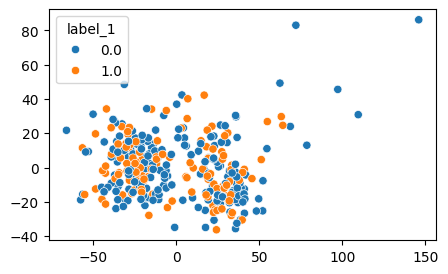

In [20]:
# PCA plot
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

# plot

plt.figure(figsize=(5, 3))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y)

/Users/zhounan/miniconda3/envs/RIF/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'K-means clustering to 2 clusters')

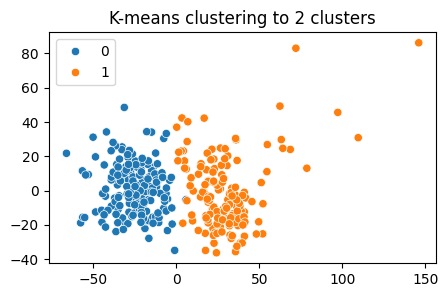

In [21]:
# K-means clustering to 2 cluster
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# if kmeans.labels_ [0] == 0, fine 
# if not, convert the all labels
if kmeans.labels_[0] == 0:
    pass
else:
    kmeans.labels_ = 1 - kmeans.labels_

# plot
plt.figure(figsize=(5, 3))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans.labels_)
plt.title('K-means clustering to 2 clusters')

In [22]:
# PCA plot
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
cluster = kmeans.predict(X)

/Users/zhounan/miniconda3/envs/RIF/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [23]:
# data split to data_0, data_1 by kmeans labels

data_0 = data[kmeans.labels_ == 0]
data_1 = data[kmeans.labels_ == 1]

data_0 = data_0.reset_index(drop=True)
data_1 = data_1.reset_index(drop=True)

# print target distribution in data_0 and data_1
print(f"Target distribution in data_0: {data_0[target].value_counts()}")
print(f"Target distribution in data_1: {data_1[target].value_counts()}")
print(f"Target distribution in data: {data[target].value_counts()}")

# print percentage of 1 in data_0 and data_1 and data
print(f"Percentage of 1 in data_0: {data_0[target].value_counts()[1] / len(data_0)}")
print(f"Percentage of 1 in data_1: {data_1[target].value_counts()[1] / len(data_1)}")
print(f"Percentage of 1 in data: {data[target].value_counts()[1] / len(data)}")

# print percentage of 0 in data_0 and data_1 and data
print(f"Percentage of 0 in data_0: {data_0[target].value_counts()[0] / len(data_0)}")
print(f"Percentage of 0 in data_1: {data_1[target].value_counts()[0] / len(data_1)}")
print(f"Percentage of 0 in data: {data[target].value_counts()[0] / len(data)}")

Target distribution in data_0: label_1
0.0    93
1.0    56
Name: count, dtype: int64
Target distribution in data_1: label_1
0.0    107
1.0     72
Name: count, dtype: int64
Target distribution in data: label_1
0.0    200
1.0    128
Name: count, dtype: int64
Percentage of 1 in data_0: 0.37583892617449666
Percentage of 1 in data_1: 0.4022346368715084
Percentage of 1 in data: 0.3902439024390244
Percentage of 0 in data_0: 0.6241610738255033
Percentage of 0 in data_1: 0.5977653631284916
Percentage of 0 in data: 0.6097560975609756


In [24]:
# distance 

KL_0, BC_0, ID_0, KS_0 = MS(data_0, target)
KL_1, BC_1, ID_1, KS_1 = MS(data_1, target)
KL, BC, ID, KS = MS(data, target)

# save to 2 digits
print(f"Measure for Separability of Two Classes (MS) in data_0, KL: {round(KL_0, 2)}, BC: {round(BC_0, 2)}, ID: {round(ID_0, 2)}, KS: {round(KS_0, 2)}")
print(f"Measure for Separability of Two Classes (MS) in data_1, KL: {round(KL_1, 2)}, BC: {round(BC_1, 2)}, ID: {round(ID_1, 2)}, KS: {round(KS_1, 2)}")
print(f"Measure for Separability of Two Classes (MS) in data, KL: {round(KL, 2)}, BC: {round(BC, 2)}, ID: {round(ID, 2)}, KS: {round(KS, 2)}")

Measure for Separability of Two Classes (MS) in data_0, KL: 12.22, BC: -6.06, ID: 3.01, KS: 67.82
Measure for Separability of Two Classes (MS) in data_1, KL: 10.58, BC: -6.24, ID: 2.53, KS: 75.93
Measure for Separability of Two Classes (MS) in data, KL: 7.33, BC: -6.91, ID: 2.13, KS: 72.25


In [25]:
X = data.drop(columns=[target])
y = data[target]

if n != 0:
    X_val = data_val.drop(columns=[target])
    y_val = data_val[target]

In [26]:
data_train_copy = data.copy()
data_val_copy = data_val.copy()

In [27]:
# PCA 999% on X
pca = PCA(n_components=0.999, svd_solver='full')
X_pca = pca.fit_transform(X)
# array to dataframe with columns name 
X_pca = pd.DataFrame(X_pca, columns=[f"component_{i}" for i in range(X_pca.shape[1])])

X_feature_importance = pca.components_

if n != 0:
    X_val_pca = pca.transform(X_val)
    X_val_pca = pd.DataFrame(X_val_pca, columns=[f"component_{i}" for i in range(X_val_pca.shape[1])])
    
print(f"X_pca shape: {X_pca.shape}")
print(f"X_val_pca shape: {X_val_pca.shape}")

X_pca shape: (328, 326)
X_val_pca shape: (70, 326)


In [28]:
# reset index
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

if n != 0:
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)

In [29]:
# updata X_0 and data_0
# updata X and data
X = X_pca
data = pd.concat([X, y], axis=1)

if n != 0:
    X_val = X_val_pca
    data_val = pd.concat([X_val, y_val], axis=1)

In [30]:
# function to random split data 
from sklearn.model_selection import train_test_split
def random_split_data(data, target, random_seed):
    X = data.drop(columns=[target])
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    return X_train, X_test, y_train, y_test

In [31]:
X = data.drop(columns=[target])
y = data[target]

if n != 0:
    X_val = data_val.drop(columns=[target])
    y_val = data_val[target]

# exp_log

In [32]:
# load the data
import json 

# if exp_log_version.json do not exist, create it
exp_log_path = f'RIF//result/exp_log_{version}.json'

if not os.path.exists(exp_log_path):
    with open(exp_log_path, 'w') as f:
        json.dump({}, f)
        
# load the data
with open(exp_log_path, 'r') as f:
    exp_log = json.load(f)

In [33]:
exp_model = ['LogisticRegression', "SVM", "Ridge", "Lasso",  "NaiveBayes", "NeuralNetwork", "XGBoost", "LightGBM", "CatBoost"]
exp_log['version'] = version
exp_short_name = ['LogReg', 'SVM', 'Ridge', 'Lasso', 'NB', 'NN', 'XGB', 'LGB', 'CB']
exp_log['model_short_name'] = exp_short_name
exp_log['model_list'] = exp_model
for i in exp_model:
    if i not in exp_log.keys():
        exp_log[i] = {} 

# logis regression

In [34]:
# function to train model and evaluate model use logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
def train_evaluate_model(data, target, random_seed, data_val=None):
    # mute the all warning
    warnings.filterwarnings("ignore")
    X_train, X_test, y_train, y_test = random_split_data(data, target, random_seed)
    
    
    # # grid search for hyperparameter C in logistic regression
    # from sklearn.model_selection import GridSearchCV
    # param_grid = {'C': [0.05, 0.1, 1, 10, 20]}
    
    # best_hyperparams = GridSearchCV(LogisticRegression(random_state=random_seed, class_weight='balanced'), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose= 4).fit(X_train, y_train).best_params_
    # print(f"Best hyperparams: {best_hyperparams}")
    
    model = LogisticRegression(random_state=random_seed, class_weight='balanced')
    model.fit(X_train, y_train)
    
    # adjust the threshold to avoid low specificity
    threshold = 0.33
    
    y_pred = model.predict(X_test)
    prod = model.predict_proba(X_test)[:, 1]
    y_pred = [1 if i > threshold else 0 for i in prod]
    
    ba, mcc, f1, cm, sen, spe = evaluation(y_test, y_pred)
    
    # also output the probs for roc
    probs = model.predict_proba(X_test)[:, 1]
    
    auc_dic = {}
    auc_dic['probs'] = probs
    auc_dic['y_test'] = y_test
    auc_dic['y_pred'] = y_pred
    auc_dic['X_test'] = [list(X_test.iloc[i]) for i in range(len(X_test))]
    
    # importance 
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=random_seed)
    importance = result.importances
    importance = np.mean(importance, axis=1)
    if data_val is not None:
        X_val = data_val.drop(columns=[target])
        y_val = data_val[target]
        y_pred_val = model.predict(X_val)
        prod_val = model.predict_proba(X_val)[:, 1]
        y_pred_val = [1 if i > threshold else 0 for i in prod_val]
        
        auc_val_dic = {}
        auc_val_dic['probs'] = prod_val
        auc_val_dic['y_test'] = y_val
        auc_val_dic['y_pred'] = y_pred_val
        
        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val,  = evaluation(y_val, y_pred_val)
        return {'test': [ba, mcc, f1, cm, sen, spe, auc_dic, importance], 'val': [ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_val_dic]}
    
    return ba, mcc, f1, cm, sen, spe, auc_dic,importance

random_seed = np.random.randint(0, 100)

dic = train_evaluate_model(data, target, random_seed, data_val)

ba, mcc, f1, cm, sen, spe, auc_dic, importance = dic['test']
ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, _ = dic['val']

print(f"Model test: BA: {ba}, MCC: {mcc}, F1: {f1}, CM: {cm}, Sensitivity: {sen}, Specificity: {spe}")
print(f"Model val: BA: {ba_val}, MCC: {mcc_val}, F1: {f1_val}, CM: {cm_val}, Sensitivity: {sen_val}, Specificity: {spe_val}")

Model test: BA: 0.8447033898305085, MCC: 0.6867926303614407, F1: 0.8148148148148149, CM: [[51  8]
 [ 7 33]], Sensitivity: 0.864406779661017, Specificity: 0.825
Model val: BA: 0.5714285714285714, MCC: 0.14309095175803563, F1: 0.5588235294117646, CM: [[21 14]
 [16 19]], Sensitivity: 0.6, Specificity: 0.5428571428571428


In [35]:
# num of experiment 
num_exp = 50
model_name = 'LogisticRegression'
threshold = 0
save = True

if True:
    ba_list = []
    mcc_list = []
    f1_list = []
    sen_list = []
    spe_list = []
    importance_dic = {}
    auc_dic = {}

    ba_val_list = []
    mcc_val_list = []
    f1_val_list = []
    sen_val_list = []
    spe_val_list = []
    auc_dic_val = {}

# check existence of result in exp_log
if 'auc_dic' in exp_log[model_name].keys():
    # run the experiment
    for i in tqdm(range(num_exp)):
        random_seed = np.random.randint(0, 100)
        dic = train_evaluate_model(data, target, random_seed, data_val)
        ba_avg, mcc_avg, f1_avg, cm_avg, sen_avg, spe_avg, auc_dic_avg, importance_avg = dic['test']
        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val_avg = dic['val']
        ba_list.append(ba_avg)
        mcc_list.append(mcc_avg)
        f1_list.append(f1_avg)
        sen_list.append(sen_avg)
        spe_list.append(spe_avg)
        
        importance_avg = list(importance_avg.T @ X_feature_importance)
        importance_avg = [(col_name[i], importance_avg[i]) for i in range(len(importance_avg))]
        importance_avg = sorted(importance_avg, key=lambda x: abs(x[1]), reverse=True)
        
        auc_dic[i] = {}
        auc_dic[i]['avg'] = {}
        auc_dic[i]['avg'] = auc_dic_avg
        
        importance_dic[i] = {}
        importance_dic[i]['avg'] = {}
        importance_dic[i]['avg'] = importance_avg
        
        ba_val_list.append(ba_val)
        mcc_val_list.append(mcc_val)
        f1_val_list.append(f1_val)
        sen_val_list.append(sen_val)
        spe_val_list.append(spe_val)
        
        auc_dic_val[i] = {}
        auc_dic_val[i]['avg'] = {}
        auc_dic_val[i]['avg'] = auc_dic_val_avg
        
    # process the result
    if True:
        remove_key = []
        keys = list(importance_dic.keys())
        for i in keys:
            if type(i) != int:
                # convert to int
                importance_dic[int(i)] = importance_dic[i]
                # delete the original key
                remove_key.append(i)
                
        for i in remove_key:
            importance_dic.pop(i)

        # change all type of root of the value in auc_dic to list 
        for i in auc_dic:
            for j in auc_dic[i]:
                for k in auc_dic[i][j]:
                    auc_dic[i][j][k] = list(auc_dic[i][j][k]) 
            
        for i in auc_dic_val:
            for j in auc_dic_val[i]:
                for k in auc_dic_val[i][j]:
                    auc_dic_val[i][j][k] = list(auc_dic_val[i][j][k])
    
    # filter 
    if True:       
        average_auc_score_list = auc_plot(auc_dic, data = 'avg', cal = True)
        auc_score_list = [1 if i > threshold else 0 for i in average_auc_score_list]

        # only keep the trial that is larger than threshold for val 
        ba_val_list = [ba_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        mcc_val_list = [mcc_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1] 
        f1_val_list = [f1_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        sen_val_list = [sen_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        spe_val_list = [spe_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]

        auc_dic_val = {k: auc_dic_val[k] for k in range(len(auc_score_list)) if auc_score_list[k] == 1}

        # reorder the auc_dic_val
        new_key_list = list(auc_dic_val.keys())
        new_aic_dic_val = {}
        for i in range(len(new_key_list)):
            new_aic_dic_val[i] = auc_dic_val[new_key_list[i]]
            auc_dic_val.pop(new_key_list[i])

        # update the auc_dic_val
        auc_dic_val = new_aic_dic_val

        print(f"Number of trial that is larger than threshold: {len(auc_score_list)}")
    
    if save:
        # exp_log 
        exp_log[model_name]['ba_avg'] = list(ba_list)
        exp_log[model_name]['mcc_avg'] = list(mcc_list)
        exp_log[model_name]['f1_avg'] = list(f1_list)
        exp_log[model_name]['sen_avg'] = list(sen_list)
        exp_log[model_name]['spe_avg'] = list(spe_list)
        exp_log[model_name]['auc_dic'] = auc_dic
        exp_log[model_name]['importance_dic'] = importance_dic

        exp_log[model_name]['ba_val_avg'] = list(ba_val_list)
        exp_log[model_name]['mcc_val_avg'] = list(mcc_val_list)
        exp_log[model_name]['f1_val_avg'] = list(f1_val_list)
        exp_log[model_name]['sen_val_avg'] = list(sen_val_list)
        exp_log[model_name]['spe_val_avg'] = list(spe_val_list)
        exp_log[model_name]['auc_dic_val'] = auc_dic_val

        # save the log
        with open(f'RIF/result/exp_log_{version}.json', 'w') as f:
            json.dump(exp_log, f, indent=4)

# SVM

In [36]:

# SVM 
from sklearn.svm import SVC

def train_evaluate_model_SVC(data, target, random_seed, data_val=None):
    # mute the all warning
    warnings.filterwarnings("ignore")
    X_train, X_test, y_train, y_test = random_split_data(data, target, random_seed)
    
    # hyperparameter tuning for SVM 
    hyperparameter = {'C': [1,5,10],   # 1 5 10 50 100
              'gamma': [0.00005,0.0001],  # 0.00001 0.00005 0.0001 0.0005
              'kernel': ['rbf']} 
    from sklearn.model_selection import GridSearchCV
    grid = GridSearchCV(SVC(), hyperparameter, refit=True, verbose=0)
    grid.fit(X_train, y_train)
    
    # best hyperparameter
    # print(grid.best_params_)
    
    model = SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], kernel=grid.best_params_['kernel'], random_state=random_seed, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # threshold = 0.5
    # prob = model.decision_function(X_test)
    # y_pred = [1 if i > threshold else 0 for i in prob]
    decision = model.decision_function(X_test)
    # convert decision to probability
    probs = (decision - min(decision)) / (max(decision) - min(decision))
    
    threshold = 0.55
    y_pred = [1 if i > threshold else 0 for i in probs]
    # print(probs)
    
    # importance 
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=random_seed)
    importance = result.importances
    importance = np.mean(importance, axis=1)
    
    ba, mcc, f1, cm, sen, spe = evaluation(y_test, y_pred)
    
    auc_dic = {}
    auc_dic['probs'] = probs
    auc_dic['y_test'] = y_test
    auc_dic['y_pred'] = y_pred
    auc_dic['X_test'] = [list(X_test.iloc[i]) for i in range(len(X_test))]
    
    if data_val is not None:
        X_val = data_val.drop(columns=[target])
        y_val = data_val[target]
        y_pred_val = model.predict(X_val)
        decision_val = model.decision_function(X_val)
        probs_val = (decision_val - min(decision_val)) / (max(decision_val) - min(decision_val))
        y_pred_val = [1 if i > threshold else 0 for i in probs_val]
        
        auc_val_dic = {}
        auc_val_dic['probs'] = probs_val
        auc_val_dic['y_test'] = y_val
        auc_val_dic['y_pred'] = y_pred_val
        
        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val = evaluation(y_val, y_pred_val)
        return {'test': [ba, mcc, f1, cm, sen, spe, auc_dic, grid.best_params_, importance], 'val': [ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_val_dic]}
    
    
    return ba, mcc, f1, cm, sen, spe, auc_dic,grid.best_params_, importance

# model 0 and model 1
random_seed = np.random.randint(0, 100)

dic = train_evaluate_model_SVC(data, target, random_seed, data_val)

ba, mcc, f1, cm, sen, spe, auc_dic, _, importance = dic['test']
ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val = dic['val']

print(f"Model test: BA: {ba}, MCC: {mcc}, F1: {f1}, CM: {cm}, Sensitivity: {sen}, Specificity: {spe}")
print(f"Model val: BA: {ba_val}, MCC: {mcc_val}, F1: {f1_val}, CM: {cm_val}, Sensitivity: {sen_val}, Specificity: {spe_val}")

Model test: BA: 0.8349453322119429, MCC: 0.6859434691497235, F1: 0.8051948051948052, CM: [[53  5]
 [10 31]], Sensitivity: 0.9137931034482759, Specificity: 0.7560975609756098
Model val: BA: 0.5285714285714286, MCC: 0.05735393346764044, F1: 0.5074626865671641, CM: [[20 15]
 [18 17]], Sensitivity: 0.5714285714285714, Specificity: 0.4857142857142857


In [37]:
# num of experiment 
num_exp = 50
model_name = 'SVM'
threshold = 0
save = True

if True:
    ba_list = []
    mcc_list = []
    f1_list = []
    sen_list = []
    spe_list = []
    p_avg_list = []

    importance_dic = {}

    ba_val_list = []
    mcc_val_list = []
    f1_val_list = []
    sen_val_list = []
    spe_val_list = []

    auc_dic = {}
    auc_dic_val = {}
    

# check existence of result in exp_log
if 'auc_dic' in exp_log[model_name].keys():
    # run the experiment
    for i in tqdm(range(num_exp)):
        random_seed = np.random.randint(0, 100)
        
        dic = train_evaluate_model_SVC(data, target, random_seed, data_val)
        ba_avg, mcc_avg, f1_avg, cm_avg, sen_avg, spe_avg, auc_dic_avg, p_avg, importance_avg = dic['test']
        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val_avg = dic['val']
        
        ba_list.append(ba_avg)
        mcc_list.append(mcc_avg)
        f1_list.append(f1_avg)
        sen_list.append(sen_avg)
        spe_list.append(spe_avg)
        p_avg_list.append(p_avg)
        
        importance_avg = list(importance_avg.T @ X_feature_importance)
        importance_avg = [(col_name[i], importance_avg[i]) for i in range(len(importance_avg))]
        importance_avg = sorted(importance_avg, key=lambda x: abs(x[1]), reverse=True)
        
        auc_dic[i] = {}
        auc_dic[i]['avg'] = {}
        auc_dic[i]['avg'] = auc_dic_avg
        
        importance_dic[i] = {}
        importance_dic[i]['avg'] = {}
        importance_dic[i]['avg'] = importance_avg
        
        ba_val_list.append(ba_val)
        mcc_val_list.append(mcc_val)
        f1_val_list.append(f1_val)
        sen_val_list.append(sen_val)
        spe_val_list.append(spe_val)
        
        auc_dic_val[i] = {}
        auc_dic_val[i]['avg'] = {}
        auc_dic_val[i]['avg'] = auc_dic_val_avg
        
    
    # process the result
    if True:
        remove_key = []
        keys = list(importance_dic.keys())
        for i in keys:
            if type(i) != int:
                # convert to int
                importance_dic[int(i)] = importance_dic[i]
                # delete the original key
                remove_key.append(i)
                
        for i in remove_key:
            importance_dic.pop(i)

        # change all type of root of the value in auc_dic to list 
        for i in auc_dic:
            for j in auc_dic[i]:
                for k in auc_dic[i][j]:
                    auc_dic[i][j][k] = list(auc_dic[i][j][k]) 
            
        for i in auc_dic_val:
            for j in auc_dic_val[i]:
                for k in auc_dic_val[i][j]:
                    auc_dic_val[i][j][k] = list(auc_dic_val[i][j][k])
    
    # filter 
    if True:       
        average_auc_score_list = auc_plot(auc_dic, data = 'avg', cal = True)
        auc_score_list = [1 if i > threshold else 0 for i in average_auc_score_list]

        # only keep the trial that is larger than threshold for val 
        ba_val_list = [ba_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        mcc_val_list = [mcc_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1] 
        f1_val_list = [f1_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        sen_val_list = [sen_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        spe_val_list = [spe_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]

        auc_dic_val = {k: auc_dic_val[k] for k in range(len(auc_score_list)) if auc_score_list[k] == 1}

        # reorder the auc_dic_val
        new_key_list = list(auc_dic_val.keys())
        new_aic_dic_val = {}
        for i in range(len(new_key_list)):
            new_aic_dic_val[i] = auc_dic_val[new_key_list[i]]
            auc_dic_val.pop(new_key_list[i])

        # update the auc_dic_val
        auc_dic_val = new_aic_dic_val

        print(f"Number of trial that is larger than threshold: {len(auc_score_list)}")
    
    if save:
        # exp_log 
        exp_log[model_name]['ba_avg'] = list(ba_list)
        exp_log[model_name]['mcc_avg'] = list(mcc_list)
        exp_log[model_name]['f1_avg'] = list(f1_list)
        exp_log[model_name]['sen_avg'] = list(sen_list)
        exp_log[model_name]['spe_avg'] = list(spe_list)
        exp_log[model_name]['auc_dic'] = auc_dic
        exp_log[model_name]['importance_dic'] = importance_dic
        exp_log[model_name]['p_avg'] = list(p_avg_list)

        exp_log[model_name]['ba_val_avg'] = list(ba_val_list)
        exp_log[model_name]['mcc_val_avg'] = list(mcc_val_list)
        exp_log[model_name]['f1_val_avg'] = list(f1_val_list)
        exp_log[model_name]['sen_val_avg'] = list(sen_val_list)
        exp_log[model_name]['spe_val_avg'] = list(spe_val_list)
        exp_log[model_name]['auc_dic_val'] = auc_dic_val

        # save the log
        with open(f'RIF/result/exp_log_{version}.json', 'w') as f:
            json.dump(exp_log, f, indent=4)

# ridge regression

In [38]:

# ridge regression
from sklearn.linear_model import Ridge

def train_evaluate_model_Ridge(data, target, random_seed, data_val = None):
    
    # mute the all warning
    warnings.filterwarnings("ignore")
    X_train, X_test, y_train, y_test = random_split_data(data, target, random_seed)
    
    # hyperparameter tuning for Ridge 
    hyperparameter = {'alpha': [0.1, 1, 10, 100, 1000]} 
    from sklearn.model_selection import GridSearchCV
    grid = GridSearchCV(Ridge(), hyperparameter, refit=True, verbose=0)
    grid.fit(X_train, y_train)
    
    # best hyperparameter
    # print(grid.best_params_)
    
    model = Ridge(alpha=grid.best_params_['alpha'], random_state=random_seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    probs = model.predict(X_test)
    
    threshold = 0.2
    y_pred = [1 if i > threshold else 0 for i in probs]
    # print(probs)
    
    ba, mcc, f1, cm, sen, spe = evaluation(y_test, y_pred)
    
    auc_dic = {}
    auc_dic['probs'] = probs
    auc_dic['y_test'] = y_test
    auc_dic['y_pred'] = y_pred
    auc_dic['X_test'] = [list(X_test.iloc[i]) for i in range(len(X_test))]
    
    # importance 
    importance = model.coef_
    
    if data_val is not None:
        X_val = data_val.drop(columns=[target])
        y_val = data_val[target]
        probs = model.predict(X_val)
        
        y_val_pred = [1 if i > threshold else 0 for i in probs]
        
        auc_dic_val = {}
        
        auc_dic_val['probs'] = probs
        auc_dic_val['y_test'] = y_val
        auc_dic_val['y_pred'] = y_val_pred

        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val = evaluation(y_val, y_val_pred)
        
        return {"test": [ba, mcc, f1, cm, sen, spe, auc_dic, grid.best_params_, importance], "val": [ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val]}
    
    return ba, mcc, f1, cm, sen, spe, auc_dic, grid.best_params_, importance

# model 0 and model 1
random_seed = np.random.randint(0, 100)

dic = train_evaluate_model_Ridge(data, target, random_seed, data_val)

ba, mcc, f1, cm, sen, spe, auc_dic, _, importance = dic["test"]
ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, _ = dic["val"]
# comperhensive evaluation

print(f"Model test: BA: {ba}, MCC: {mcc}, F1: {f1}, CM: {cm}, Sensitivity: {sen}, Specificity: {spe}")
print(f"Model val: BA: {ba_val}, MCC: {mcc_val}, F1: {f1_val}, CM: {cm_val}, Sensitivity: {sen_val}, Specificity: {spe_val}")

Model test: BA: 0.6977272727272728, MCC: 0.45853026072441505, F1: 0.722689075630252, CM: [[23 32]
 [ 1 43]], Sensitivity: 0.41818181818181815, Specificity: 0.9772727272727273
Model val: BA: 0.5142857142857142, MCC: 0.05547001962252292, F1: 0.6599999999999999, CM: [[ 3 32]
 [ 2 33]], Sensitivity: 0.08571428571428572, Specificity: 0.9428571428571428


In [39]:
# num of experiment 
num_exp = 50
model_name = 'Ridge'
threshold = 0
save = True

if True:
    ba_list = []
    mcc_list = []
    f1_list = []
    sen_list = []
    spe_list = []
    p_avg_list = []

    importance_dic = {}

    ba_val_list = []
    mcc_val_list = []
    f1_val_list = []
    sen_val_list = []
    spe_val_list = []

    auc_dic = {}
    auc_dic_val = {}
    

# check existence of result in exp_log
if 'auc_dic' not in exp_log[model_name].keys():
    # run the experiment
    for i in tqdm(range(num_exp)):
        random_seed = np.random.randint(0, 100)
        
        dic = train_evaluate_model_Ridge(data, target, random_seed, data_val)
        ba_avg, mcc_avg, f1_avg, cm_avg, sen_avg, spe_avg, auc_dic_avg, p_avg, importance_avg = dic['test']
        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val_avg = dic['val']
        
        ba_list.append(ba_avg)
        mcc_list.append(mcc_avg)
        f1_list.append(f1_avg)
        sen_list.append(sen_avg)
        spe_list.append(spe_avg)
        p_avg_list.append(p_avg)
        
        importance_avg = list(importance_avg.T @ X_feature_importance)
        importance_avg = [(col_name[i], importance_avg[i]) for i in range(len(importance_avg))]
        importance_avg = sorted(importance_avg, key=lambda x: abs(x[1]), reverse=True)
        
        auc_dic[i] = {}
        auc_dic[i]['avg'] = {}
        auc_dic[i]['avg'] = auc_dic_avg
        
        importance_dic[i] = {}
        importance_dic[i]['avg'] = {}
        importance_dic[i]['avg'] = importance_avg
        
        ba_val_list.append(ba_val)
        mcc_val_list.append(mcc_val)
        f1_val_list.append(f1_val)
        sen_val_list.append(sen_val)
        spe_val_list.append(spe_val)
        
        auc_dic_val[i] = {}
        auc_dic_val[i]['avg'] = {}
        auc_dic_val[i]['avg'] = auc_dic_val_avg
        
    
    # process the result
    if True:
        remove_key = []
        keys = list(importance_dic.keys())
        for i in keys:
            if type(i) != int:
                # convert to int
                importance_dic[int(i)] = importance_dic[i]
                # delete the original key
                remove_key.append(i)
                
        for i in remove_key:
            importance_dic.pop(i)

        # change all type of root of the value in auc_dic to list 
        for i in auc_dic:
            for j in auc_dic[i]:
                for k in auc_dic[i][j]:
                    auc_dic[i][j][k] = list(auc_dic[i][j][k]) 
            
        for i in auc_dic_val:
            for j in auc_dic_val[i]:
                for k in auc_dic_val[i][j]:
                    auc_dic_val[i][j][k] = list(auc_dic_val[i][j][k])
    
    # filter 
    if True:       
        average_auc_score_list = auc_plot(auc_dic, data = 'avg', cal = True)
        auc_score_list = [1 if i > threshold else 0 for i in average_auc_score_list]

        # only keep the trial that is larger than threshold for val 
        ba_val_list = [ba_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        mcc_val_list = [mcc_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1] 
        f1_val_list = [f1_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        sen_val_list = [sen_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        spe_val_list = [spe_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]

        auc_dic_val = {k: auc_dic_val[k] for k in range(len(auc_score_list)) if auc_score_list[k] == 1}

        # reorder the auc_dic_val
        new_key_list = list(auc_dic_val.keys())
        new_aic_dic_val = {}
        for i in range(len(new_key_list)):
            new_aic_dic_val[i] = auc_dic_val[new_key_list[i]]
            auc_dic_val.pop(new_key_list[i])

        # update the auc_dic_val
        auc_dic_val = new_aic_dic_val

        print(f"Number of trial that is larger than threshold: {len(auc_score_list)}")
    
    if save:
        # exp_log 
        exp_log[model_name]['ba_avg'] = list(ba_list)
        exp_log[model_name]['mcc_avg'] = list(mcc_list)
        exp_log[model_name]['f1_avg'] = list(f1_list)
        exp_log[model_name]['sen_avg'] = list(sen_list)
        exp_log[model_name]['spe_avg'] = list(spe_list)
        exp_log[model_name]['auc_dic'] = auc_dic
        exp_log[model_name]['importance_dic'] = importance_dic
        exp_log[model_name]['p_avg'] = list(p_avg_list)

        exp_log[model_name]['ba_val_avg'] = list(ba_val_list)
        exp_log[model_name]['mcc_val_avg'] = list(mcc_val_list)
        exp_log[model_name]['f1_val_avg'] = list(f1_val_list)
        exp_log[model_name]['sen_val_avg'] = list(sen_val_list)
        exp_log[model_name]['spe_val_avg'] = list(spe_val_list)
        exp_log[model_name]['auc_dic_val'] = auc_dic_val

        # save the log
        with open(f'RIF/result/exp_log_{version}.json', 'w') as f:
            json.dump(exp_log, f, indent=4)

100%|██████████| 50/50 [00:06<00:00,  7.43it/s]


Number of trial that is larger than threshold: 50


# Lasso

In [40]:
from sklearn.linear_model import Lasso

def train_evaluate_model_Lasso(data, target, random_seed, data_val = None):
        
        # mute the all warning
        warnings.filterwarnings("ignore")
        X_train, X_test, y_train, y_test = random_split_data(data, target, random_seed)
        
        # hyperparameter tuning for Lasso 
        hyperparameter = {'alpha': [0.0001,0.001, 0.05, 0.1, 0.5]} 
        from sklearn.model_selection import GridSearchCV
        grid = GridSearchCV(Lasso(), hyperparameter, refit=True, verbose=0)
        grid.fit(X_train, y_train)
        
        # best hyperparameter
        # print(grid.best_params_)
        
        model = Lasso(alpha=grid.best_params_['alpha'], random_state=random_seed)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        probs = model.predict(X_test)
        
        threshold = 0.4
        y_pred = [1 if i > threshold else 0 for i in probs]
        # print(probs)
        
        ba, mcc, f1, cm, sen, spe = evaluation(y_test, y_pred)
        
        auc_dic = {}
        auc_dic['probs'] = probs
        auc_dic['y_test'] = y_test
        auc_dic['y_pred'] = y_pred
        auc_dic['X_test'] = [list(X_test.iloc[i]) for i in range(len(X_test))]
        
        # importance 
        importance = model.coef_
        
        if data_val is not None:
                X_val = data_val.drop(columns=[target])
                y_val = data_val[target]
                probs = model.predict(X_val)
                
                y_val_pred = [1 if i > threshold else 0 for i in probs]
                
                auc_dic_val = {}
                
                auc_dic_val['probs'] = probs
                auc_dic_val['y_test'] = y_val
                auc_dic_val['y_pred'] = y_val_pred
        
                ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val = evaluation(y_val, y_val_pred)
                
                return {"test": [ba, mcc, f1, cm, sen, spe, auc_dic, grid.best_params_, importance], "val": [ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val]}
        
        return ba, mcc, f1, cm, sen, spe, auc_dic,grid.best_params_, importance

# model 0 and model 1
random_seed = np.random.randint(0, 100)

dic = train_evaluate_model_Lasso(data, target, random_seed, data_val)

ba, mcc, f1, cm, sen, spe, auc_dic, _, importance = dic["test"]
ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, _ = dic["val"]

# comperhensive evaluation

print(f"Model test: BA: {ba}, MCC: {mcc}, F1: {f1}, CM: {cm}, Sensitivity: {sen}, Specificity: {spe}")
print(f"Model val: BA: {ba_val}, MCC: {mcc_val}, F1: {f1_val}, CM: {cm_val}, Sensitivity: {sen_val}, Specificity: {spe_val}")

Model test: BA: 0.8035714285714286, MCC: 0.58487332489399, F1: 0.7469879518072289, CM: [[47 16]
 [ 5 31]], Sensitivity: 0.746031746031746, Specificity: 0.8611111111111112
Model val: BA: 0.5285714285714286, MCC: 0.05735393346764044, F1: 0.547945205479452, CM: [[17 18]
 [15 20]], Sensitivity: 0.4857142857142857, Specificity: 0.5714285714285714


In [41]:
# num of experiment 
num_exp = 50
model_name = 'Lasso'
threshold = 0
save = True

if True:
    ba_list = []
    mcc_list = []
    f1_list = []
    sen_list = []
    spe_list = []
    p_avg_list = []

    importance_dic = {}

    ba_val_list = []
    mcc_val_list = []
    f1_val_list = []
    sen_val_list = []
    spe_val_list = []

    auc_dic = {}
    auc_dic_val = {}
    

# check existence of result in exp_log
if 'auc_dic' not in exp_log[model_name].keys():
    # run the experiment
    for i in tqdm(range(num_exp)):
        random_seed = np.random.randint(0, 100)
        
        dic = train_evaluate_model_Lasso(data, target, random_seed, data_val)
        ba_avg, mcc_avg, f1_avg, cm_avg, sen_avg, spe_avg, auc_dic_avg, p_avg, importance_avg = dic['test']
        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val_avg = dic['val']
        
        ba_list.append(ba_avg)
        mcc_list.append(mcc_avg)
        f1_list.append(f1_avg)
        sen_list.append(sen_avg)
        spe_list.append(spe_avg)
        p_avg_list.append(p_avg)
        
        importance_avg = list(importance_avg.T @ X_feature_importance)
        importance_avg = [(col_name[i], importance_avg[i]) for i in range(len(importance_avg))]
        importance_avg = sorted(importance_avg, key=lambda x: abs(x[1]), reverse=True)
        
        auc_dic[i] = {}
        auc_dic[i]['avg'] = {}
        auc_dic[i]['avg'] = auc_dic_avg
        
        importance_dic[i] = {}
        importance_dic[i]['avg'] = {}
        importance_dic[i]['avg'] = importance_avg
        
        ba_val_list.append(ba_val)
        mcc_val_list.append(mcc_val)
        f1_val_list.append(f1_val)
        sen_val_list.append(sen_val)
        spe_val_list.append(spe_val)
        
        auc_dic_val[i] = {}
        auc_dic_val[i]['avg'] = {}
        auc_dic_val[i]['avg'] = auc_dic_val_avg
        
    
    # process the result
    if True:
        remove_key = []
        keys = list(importance_dic.keys())
        for i in keys:
            if type(i) != int:
                # convert to int
                importance_dic[int(i)] = importance_dic[i]
                # delete the original key
                remove_key.append(i)
                
        for i in remove_key:
            importance_dic.pop(i)

        # change all type of root of the value in auc_dic to list 
        for i in auc_dic:
            for j in auc_dic[i]:
                for k in auc_dic[i][j]:
                    auc_dic[i][j][k] = list(auc_dic[i][j][k]) 
            
        for i in auc_dic_val:
            for j in auc_dic_val[i]:
                for k in auc_dic_val[i][j]:
                    auc_dic_val[i][j][k] = list(auc_dic_val[i][j][k])
    
    # filter 
    if True:       
        average_auc_score_list = auc_plot(auc_dic, data = 'avg', cal = True)
        auc_score_list = [1 if i > threshold else 0 for i in average_auc_score_list]

        # only keep the trial that is larger than threshold for val 
        ba_val_list = [ba_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        mcc_val_list = [mcc_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1] 
        f1_val_list = [f1_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        sen_val_list = [sen_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        spe_val_list = [spe_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]

        auc_dic_val = {k: auc_dic_val[k] for k in range(len(auc_score_list)) if auc_score_list[k] == 1}

        # reorder the auc_dic_val
        new_key_list = list(auc_dic_val.keys())
        new_aic_dic_val = {}
        for i in range(len(new_key_list)):
            new_aic_dic_val[i] = auc_dic_val[new_key_list[i]]
            auc_dic_val.pop(new_key_list[i])

        # update the auc_dic_val
        auc_dic_val = new_aic_dic_val

        print(f"Number of trial that is larger than threshold: {len(auc_score_list)}")
    
    if save:
        # exp_log 
        exp_log[model_name]['ba_avg'] = list(ba_list)
        exp_log[model_name]['mcc_avg'] = list(mcc_list)
        exp_log[model_name]['f1_avg'] = list(f1_list)
        exp_log[model_name]['sen_avg'] = list(sen_list)
        exp_log[model_name]['spe_avg'] = list(spe_list)
        exp_log[model_name]['auc_dic'] = auc_dic
        exp_log[model_name]['importance_dic'] = importance_dic
        exp_log[model_name]['p_avg'] = list(p_avg_list)

        exp_log[model_name]['ba_val_avg'] = list(ba_val_list)
        exp_log[model_name]['mcc_val_avg'] = list(mcc_val_list)
        exp_log[model_name]['f1_val_avg'] = list(f1_val_list)
        exp_log[model_name]['sen_val_avg'] = list(sen_val_list)
        exp_log[model_name]['spe_val_avg'] = list(spe_val_list)
        exp_log[model_name]['auc_dic_val'] = auc_dic_val

        # save the log
        with open(f'RIF/result/exp_log_{version}.json', 'w') as f:
            json.dump(exp_log, f, indent=4)

100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


Number of trial that is larger than threshold: 50


# Naive Bayes

In [42]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

def train_evaluate_model_NB(data, target, random_seed, data_val = None):
    
    warnings.filterwarnings("ignore")
    X_train, X_test, y_train, y_test = random_split_data(data, target, random_seed)
    priors = np.array([len(y_train[y_train == 0])/len(y_train), len(y_train[y_train == 1])/len(y_train)])
    model = GaussianNB(priors = priors)
    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_test)[:,1]
    
    threshold = 0.5
    
    y_pred =  [1 if i > threshold else 0 for i in probs]
    
    ba, mcc, f1, cm, sen, spe = evaluation(y_test, y_pred)
    
    auc_dic = {}
    
    auc_dic['probs'] = probs
    auc_dic['y_test'] = y_test
    auc_dic['y_pred'] = y_pred
    auc_dic['X_test'] = [list(X_test.iloc[i]) for i in range(len(X_test))]
    
    importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=random_seed)['importances_mean']
    
    if data_val is not None:
        
        X_val = data_val.drop(columns=[target])
        y_val = data_val[target]
        probs = model.predict_proba(X_val)[:,1]
        
        y_val_pred = [1 if i > threshold else 0 for i in probs]
        
        auc_dic_val = {}
        
        auc_dic_val['probs'] = probs
        auc_dic_val['y_test'] = y_val
        auc_dic_val['y_pred'] = y_val_pred
        
        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val = evaluation(y_val, y_val_pred)
        
        return {"test": [ba, mcc, f1, cm, sen, spe, auc_dic, {}, importance], "val": [ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val]}
    
    return ba, mcc, f1, cm, sen, spe, auc_dic, {}, importance

# model 0 and model 1
random_seed = np.random.randint(0, 100)

dic = train_evaluate_model_NB(data, target, random_seed, data_val)

ba, mcc, f1, cm, sen, spe, auc_dic, _, importance = dic["test"]

ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, _ = dic["val"]

# comperhensive evaluation

print(f"Model test: BA: {ba}, MCC: {mcc}, F1: {f1}, CM: {cm}, Sensitivity: {sen}, Specificity: {spe}")
print(f"Model val: BA: {ba_val}, MCC: {mcc_val}, F1: {f1_val}, CM: {cm_val}, Sensitivity: {sen_val}, Specificity: {spe_val}")

Model test: BA: 0.48899913718723037, MCC: -0.023282429016730263, F1: 0.32352941176470584, CM: [[42 19]
 [27 11]], Sensitivity: 0.6885245901639344, Specificity: 0.2894736842105263
Model val: BA: 0.5, MCC: 0.0, F1: 0.3137254901960784, CM: [[27  8]
 [27  8]], Sensitivity: 0.7714285714285715, Specificity: 0.22857142857142856


In [43]:
# num of experiment 
num_exp = 50
model_name = 'NaiveBayes'
threshold = 0
save = True

if True:
    ba_list = []
    mcc_list = []
    f1_list = []
    sen_list = []
    spe_list = []
    p_avg_list = []

    importance_dic = {}

    ba_val_list = []
    mcc_val_list = []
    f1_val_list = []
    sen_val_list = []
    spe_val_list = []

    auc_dic = {}
    auc_dic_val = {}
    

# check existence of result in exp_log
if 'auc_dic' in exp_log[model_name].keys():
    # run the experiment
    for i in tqdm(range(num_exp)):
        random_seed = np.random.randint(0, 100)
        
        dic = train_evaluate_model_NB(data, target, random_seed, data_val)
        ba_avg, mcc_avg, f1_avg, cm_avg, sen_avg, spe_avg, auc_dic_avg, p_avg, importance_avg = dic['test']
        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val_avg = dic['val']
        
        ba_list.append(ba_avg)
        mcc_list.append(mcc_avg)
        f1_list.append(f1_avg)
        sen_list.append(sen_avg)
        spe_list.append(spe_avg)
        p_avg_list.append(p_avg)
        
        importance_avg = list(importance_avg.T @ X_feature_importance)
        importance_avg = [(col_name[i], importance_avg[i]) for i in range(len(importance_avg))]
        importance_avg = sorted(importance_avg, key=lambda x: abs(x[1]), reverse=True)
        
        auc_dic[i] = {}
        auc_dic[i]['avg'] = {}
        auc_dic[i]['avg'] = auc_dic_avg
        
        importance_dic[i] = {}
        importance_dic[i]['avg'] = {}
        importance_dic[i]['avg'] = importance_avg
        
        ba_val_list.append(ba_val)
        mcc_val_list.append(mcc_val)
        f1_val_list.append(f1_val)
        sen_val_list.append(sen_val)
        spe_val_list.append(spe_val)
        
        auc_dic_val[i] = {}
        auc_dic_val[i]['avg'] = {}
        auc_dic_val[i]['avg'] = auc_dic_val_avg
        
    
    # process the result
    if True:
        remove_key = []
        keys = list(importance_dic.keys())
        for i in keys:
            if type(i) != int:
                # convert to int
                importance_dic[int(i)] = importance_dic[i]
                # delete the original key
                remove_key.append(i)
                
        for i in remove_key:
            importance_dic.pop(i)

        # change all type of root of the value in auc_dic to list 
        for i in auc_dic:
            for j in auc_dic[i]:
                for k in auc_dic[i][j]:
                    auc_dic[i][j][k] = list(auc_dic[i][j][k]) 
            
        for i in auc_dic_val:
            for j in auc_dic_val[i]:
                for k in auc_dic_val[i][j]:
                    auc_dic_val[i][j][k] = list(auc_dic_val[i][j][k])
    
    # filter 
    if True:       
        average_auc_score_list = auc_plot(auc_dic, data = 'avg', cal = True)
        auc_score_list = [1 if i > threshold else 0 for i in average_auc_score_list]

        # only keep the trial that is larger than threshold for val 
        ba_val_list = [ba_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        mcc_val_list = [mcc_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1] 
        f1_val_list = [f1_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        sen_val_list = [sen_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        spe_val_list = [spe_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]

        auc_dic_val = {k: auc_dic_val[k] for k in range(len(auc_score_list)) if auc_score_list[k] == 1}

        # reorder the auc_dic_val
        new_key_list = list(auc_dic_val.keys())
        new_aic_dic_val = {}
        for i in range(len(new_key_list)):
            new_aic_dic_val[i] = auc_dic_val[new_key_list[i]]
            auc_dic_val.pop(new_key_list[i])

        # update the auc_dic_val
        auc_dic_val = new_aic_dic_val

        print(f"Number of trial that is larger than threshold: {len(auc_score_list)}")
    
    if save:
        # exp_log 
        exp_log[model_name]['ba_avg'] = list(ba_list)
        exp_log[model_name]['mcc_avg'] = list(mcc_list)
        exp_log[model_name]['f1_avg'] = list(f1_list)
        exp_log[model_name]['sen_avg'] = list(sen_list)
        exp_log[model_name]['spe_avg'] = list(spe_list)
        exp_log[model_name]['auc_dic'] = auc_dic
        exp_log[model_name]['importance_dic'] = importance_dic
        exp_log[model_name]['p_avg'] = list(p_avg_list)

        exp_log[model_name]['ba_val_avg'] = list(ba_val_list)
        exp_log[model_name]['mcc_val_avg'] = list(mcc_val_list)
        exp_log[model_name]['f1_val_avg'] = list(f1_val_list)
        exp_log[model_name]['sen_val_avg'] = list(sen_val_list)
        exp_log[model_name]['spe_val_avg'] = list(spe_val_list)
        exp_log[model_name]['auc_dic_val'] = auc_dic_val

        # save the log
        with open(f'RIF/result/exp_log_{version}.json', 'w') as f:
            json.dump(exp_log, f, indent=4)

# Neural Network

In [44]:
# neural network
from sklearn.neural_network import MLPClassifier

def train_evaluate_model_NN(data, target, random_seed, data_val = None):
    
    # mute the all warning
    warnings.filterwarnings("ignore")
    
    X_train, X_test, y_train, y_test = random_split_data(data, target, random_seed)
    
    # architecture of the neural network
    # two layers with 15 neurons each
    model = MLPClassifier(hidden_layer_sizes=(40,20,10), max_iter=1000, random_state=random_seed, early_stopping=True, n_iter_no_change=200, tol=1e-4, activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001)
    
    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_test)[:,1]
    
    threshold = 0.5
    y_pred = [1 if i > threshold else 0 for i in probs]
    
    ba, mcc, f1, cm, sen, spe = evaluation(y_test, y_pred)
    
    auc_dic = {}
    
    auc_dic['probs'] = probs
    auc_dic['y_test'] = y_test
    auc_dic['y_pred'] = y_pred
    auc_dic['X_test'] = [list(X_test.iloc[i]) for i in range(len(X_test))]
    
    importance = model.coefs_
    
    if data_val is not None:
        X_val = data_val.drop(columns=[target])
        y_val = data_val[target]
        probs = model.predict_proba(X_val)[:,1]
        
        y_val_pred = [1 if i > threshold else 0 for i in probs]
        
        auc_dic_val = {}
        
        auc_dic_val['probs'] = probs
        auc_dic_val['y_test'] = y_val
        auc_dic_val['y_pred'] = y_val_pred
        
        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val = evaluation(y_val, y_val_pred)
        
        return {"test": [ba, mcc, f1, cm, sen, spe, auc_dic, {}, importance], "val": [ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val]}
        
    return ba, mcc, f1, cm, sen, spe, auc_dic, {}, importance
    
# model 0 and model 1
random_seed = np.random.randint(0, 100)

dic = train_evaluate_model_NN(data, target, random_seed, data_val)

ba, mcc, f1, cm, sen, spe, auc_dic, _, importance = dic["test"]
ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, _ = dic["val"]

# comperhensive evaluation
print(f"Model test: BA: {ba}, MCC: {mcc}, F1: {f1}, CM: {cm}, Sensitivity: {sen}, Specificity: {spe}")
print(f"Model val: BA: {ba_val}, MCC: {mcc_val}, F1: {f1_val}, CM: {cm_val}, Sensitivity: {sen_val}, Specificity: {spe_val}")
    

Model test: BA: 0.49206349206349204, MCC: -0.015334790207607871, F1: 0.3950617283950617, CM: [[34 29]
 [20 16]], Sensitivity: 0.5396825396825397, Specificity: 0.4444444444444444
Model val: BA: 0.5142857142857142, MCC: 0.02857142857142857, F1: 0.5142857142857142, CM: [[18 17]
 [17 18]], Sensitivity: 0.5142857142857142, Specificity: 0.5142857142857142


In [45]:
# num of experiment 
num_exp = 50
model_name = 'NeuralNetwork'
threshold = 0
save = True

if True:
    ba_list = []
    mcc_list = []
    f1_list = []
    sen_list = []
    spe_list = []
    p_avg_list = []

    importance_dic = {}

    ba_val_list = []
    mcc_val_list = []
    f1_val_list = []
    sen_val_list = []
    spe_val_list = []

    auc_dic = {}
    auc_dic_val = {}
    

# check existence of result in exp_log
if 'auc_dic' not in exp_log[model_name].keys():
    # run the experiment
    for i in tqdm(range(num_exp)):
        random_seed = np.random.randint(0, 100)
        
        dic = train_evaluate_model_NN(data, target, random_seed, data_val)
        ba_avg, mcc_avg, f1_avg, cm_avg, sen_avg, spe_avg, auc_dic_avg, p_avg, importance_avg = dic['test']
        ba_val, mcc_val, f1_val, cm_val, sen_val, spe_val, auc_dic_val_avg = dic['val']
        
        ba_list.append(ba_avg)
        mcc_list.append(mcc_avg)
        f1_list.append(f1_avg)
        sen_list.append(sen_avg)
        spe_list.append(spe_avg)
        p_avg_list.append(p_avg)
        
        importance_avg = {}
        
        auc_dic[i] = {}
        auc_dic[i]['avg'] = {}
        auc_dic[i]['avg'] = auc_dic_avg
        
        importance_dic[i] = {}
        importance_dic[i]['avg'] = {}
        importance_dic[i]['avg'] = importance_avg
        
        ba_val_list.append(ba_val)
        mcc_val_list.append(mcc_val)
        f1_val_list.append(f1_val)
        sen_val_list.append(sen_val)
        spe_val_list.append(spe_val)
        
        auc_dic_val[i] = {}
        auc_dic_val[i]['avg'] = {}
        auc_dic_val[i]['avg'] = auc_dic_val_avg
        
    
    # process the result
    if True:
        remove_key = []
        keys = list(importance_dic.keys())
        for i in keys:
            if type(i) != int:
                # convert to int
                importance_dic[int(i)] = importance_dic[i]
                # delete the original key
                remove_key.append(i)
                
        for i in remove_key:
            importance_dic.pop(i)

        # change all type of root of the value in auc_dic to list 
        for i in auc_dic:
            for j in auc_dic[i]:
                for k in auc_dic[i][j]:
                    auc_dic[i][j][k] = list(auc_dic[i][j][k]) 
            
        for i in auc_dic_val:
            for j in auc_dic_val[i]:
                for k in auc_dic_val[i][j]:
                    auc_dic_val[i][j][k] = list(auc_dic_val[i][j][k])
    
    # filter 
    if True:       
        average_auc_score_list = auc_plot(auc_dic, data = 'avg', cal = True)
        auc_score_list = [1 if i > threshold else 0 for i in average_auc_score_list]

        # only keep the trial that is larger than threshold for val 
        ba_val_list = [ba_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        mcc_val_list = [mcc_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1] 
        f1_val_list = [f1_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        sen_val_list = [sen_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]
        spe_val_list = [spe_val_list[i] for i in range(len(auc_score_list)) if auc_score_list[i] == 1]

        auc_dic_val = {k: auc_dic_val[k] for k in range(len(auc_score_list)) if auc_score_list[k] == 1}

        # reorder the auc_dic_val
        new_key_list = list(auc_dic_val.keys())
        new_aic_dic_val = {}
        for i in range(len(new_key_list)):
            new_aic_dic_val[i] = auc_dic_val[new_key_list[i]]
            auc_dic_val.pop(new_key_list[i])

        # update the auc_dic_val
        auc_dic_val = new_aic_dic_val

        print(f"Number of trial that is larger than threshold: {len(auc_score_list)}")
    
    if save:
        # exp_log 
        exp_log[model_name]['ba_avg'] = list(ba_list)
        exp_log[model_name]['mcc_avg'] = list(mcc_list)
        exp_log[model_name]['f1_avg'] = list(f1_list)
        exp_log[model_name]['sen_avg'] = list(sen_list)
        exp_log[model_name]['spe_avg'] = list(spe_list)
        exp_log[model_name]['auc_dic'] = auc_dic
        exp_log[model_name]['importance_dic'] = importance_dic
        exp_log[model_name]['p_avg'] = list(p_avg_list)

        exp_log[model_name]['ba_val_avg'] = list(ba_val_list)
        exp_log[model_name]['mcc_val_avg'] = list(mcc_val_list)
        exp_log[model_name]['f1_val_avg'] = list(f1_val_list)
        exp_log[model_name]['sen_val_avg'] = list(sen_val_list)
        exp_log[model_name]['spe_val_avg'] = list(spe_val_list)
        exp_log[model_name]['auc_dic_val'] = auc_dic_val

        # save the log
        with open(f'RIF/result/exp_log_{version}.json', 'w') as f:
            json.dump(exp_log, f, indent=4)

100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


Number of trial that is larger than threshold: 50


# Catboost

# XGBBoost

# lightbost

# Sci Plot

In [46]:
# load the log
with open(f'RIF/result/exp_log_{version}.json', 'r') as f:
    exp_log = json.load(f)
# num of experiment model 
num_exp = len(exp_log['model_list'][:6])    
model_short_list = exp_log['model_short_name'][:6]
model_list = exp_log['model_list'][:6]

num_exp = 3
model_short_list = ['Ridge', 'Lasso', 'NeuralNetwork']
model_list = ['Ridge', 'Lasso', 'NeuralNetwork']

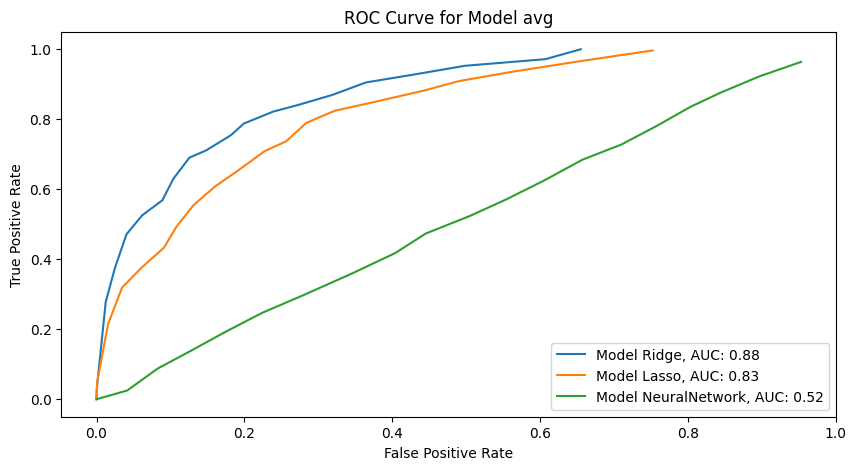

In [47]:
# average auc plot  

# 2 * 1 subplot 

plt.figure(figsize=(10, 5))

plt.subplot(1, 1, 1)
# plot 1 for model 0 
num_experiment = 50

for model in model_list:
    fpr_avg = [0] * 20
    tpr_avg = [0] * 20
    auc_avg_list = []
    for i in range(num_experiment):
        fpr, tpr, _ = roc_curve(exp_log[model]['auc_dic'][str(i)]['avg']['y_test'], exp_log[model]['auc_dic'][str(i)]['avg']['probs'])
        fpr = list(fpr)
        tpr = list(tpr)
        ## proprotionally extend the line to 20 points
        fpr = [fpr[int(i / 20 * len(fpr))] for i in range(20)]
        tpr = [tpr[int(i / 20 * len(tpr))] for i in range(20)]
        tpr_avg = [x + y for x, y in zip(tpr_avg, tpr)]
        fpr_avg = [x + y for x, y in zip(fpr_avg, fpr)]
        
        auc_avg_list.append(roc_auc_score(exp_log[model]['auc_dic'][str(i)]['avg']['y_test'], exp_log[model]['auc_dic'][str(i)]['avg']['probs']))
        
    # average line
    tpr_avg = [x / num_experiment for x in tpr_avg]
    fpr_avg = [x / num_experiment for x in fpr_avg]
    
    # calculate auc for average line using tpr_avg_1 and fpr_avg_1
    auc_avg = np.mean(auc_avg_list)
    
    # plot the average line
    plt.plot(fpr_avg, tpr_avg, label=f'Model {model}, AUC: {round(auc_avg, 2)}')  
    
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve for Model avg')

plt.show()

In [48]:
# importance analysis 
# overlap part of the importance analysis in the top 200 features in different models, at least 2 models have the feature in top 200 features

# importance_analysis_0_common = {} 
# importance_analysis_1_common = {}
importance_analysis_avg_common = {}

model_list = ["Ridge", "Lasso"]

num_exp = 50
for model in model_list:
    # importance_analysis_0_common[model] = {}
    # importance_analysis_1_common[model] = {}
    importance_analysis_avg_common[model] = {}
    
    for col in col_name:
        # importance_analysis_0_common[model][col] = {}
        # importance_analysis_0_common[model][col]['rank'] = []
        # importance_analysis_0_common[model][col]['value'] = []
        
        # importance_analysis_1_common[model][col] = {}
        # importance_analysis_1_common[model][col]['rank'] = []
        # importance_analysis_1_common[model][col]['value'] = []
        
        importance_analysis_avg_common[model][col] = {}
        importance_analysis_avg_common[model][col]['rank'] = []
        importance_analysis_avg_common[model][col]['value'] = []
        
for i in tqdm(range(num_exp)):
    for model in model_list:
        # for j, tmp in enumerate(exp_log[model]['importance_dic'][str(i)]['0']):
        #     importance_analysis_0_common[model][tmp[0]]['rank'].append(j)
        #     importance_analysis_0_common[model][tmp[0]]['value'].append(tmp[1])

        # for j, tmp in enumerate(exp_log[model]['importance_dic'][str(i)]['1']):
        #     importance_analysis_1_common[model][tmp[0]]['rank'].append(j)
        #     importance_analysis_1_common[model][tmp[0]]['value'].append(tmp[1])

        for j, tmp in enumerate(exp_log[model]['importance_dic'][str(i)]['avg']):
            importance_analysis_avg_common[model][tmp[0]]['rank'].append(j)
            importance_analysis_avg_common[model][tmp[0]]['value'].append(tmp[1])
            
# calculate the average rank and value
for model in model_list:
    for col in col_name:
        # importance_analysis_0_common[model][col]['rank_avg'] = np.mean(importance_analysis_0_common[model][col]['rank'])
        # importance_analysis_0_common[model][col]['value_avg'] = np.mean(importance_analysis_0_common[model][col]['value'])

        # importance_analysis_1_common[model][col]['rank_avg'] = np.mean(importance_analysis_1_common[model][col]['rank'])
        # importance_analysis_1_common[model][col]['value_avg'] = np.mean(importance_analysis_1_common[model][col]['value'])
        
        rank_list = importance_analysis_avg_common[model][col]['rank']
        value_list = importance_analysis_avg_common[model][col]['value']
        
        # sort the rank 
        rank_list = sorted(rank_list)
        value_list = sorted(value_list)
        
        # get rid of the highest and lowest 10% value
        rank_list = rank_list[int(len(rank_list) * 0.1): int(len(rank_list) * 0.9)]
        value_list = value_list[int(len(value_list) * 0.1): int(len(value_list) * 0.9)]

        importance_analysis_avg_common[model][col]['rank_avg'] = np.mean(importance_analysis_avg_common[model][col]['rank'])
        importance_analysis_avg_common[model][col]['value_avg'] = np.mean(importance_analysis_avg_common[model][col]['value'])
        


100%|██████████| 50/50 [00:00<00:00, 143.40it/s]


In [49]:
feature_list_top = []
count_dic = {}
threshold = 1000

for col in col_name:
    count_dic[col] = 0

for model in model_list:
    for col in col_name:
        if importance_analysis_avg_common[model][col]['rank_avg'] < threshold:
            count_dic[col] += 1
            
for col in col_name:
    if count_dic[col] >= 2:
        feature_list_top.append(col)

print(f"Number of features that are in top {threshold} features in at least 2 models: {len(feature_list_top)}")

Number of features that are in top 1000 features in at least 2 models: 212


# final plot 

In [50]:
# load the log
with open(f'RIF/result/exp_log_{version}.json', 'r') as f:
    exp_log = json.load(f)

# num of experiment model 
num_exp = len(exp_log['model_list'][:6])    
model_short_list = exp_log['model_short_name'][:6]
model_list = exp_log['model_list'][:6]

num_exp = 3
model_short_list = ['Ridge', 'Lasso', 'NeuralNetwork']
model_list = ['Ridge', 'Lasso', 'NeuralNetwork']

# output table
table = pd.DataFrame(columns=['Model', "version", 'BA', 'MCC', 'F1', 'Sen', 'Spe'])

for i in range(num_exp):
    model = model_list[i]
    model_name = model_short_list[i]
    # round to 2 decimal
    ba = round(np.mean(exp_log[model]['ba_avg']), 3)
    mcc = round(np.mean(exp_log[model]['mcc_avg']), 3)
    f1 = round(np.mean(exp_log[model]['f1_avg']), 3)
    sen = round(np.mean(exp_log[model]['sen_avg']), 3)
    spe = round(np.mean(exp_log[model]['spe_avg']), 3)
    table.loc[i] =  [model_name, 'Full', ba, mcc, f1, sen, spe]
    
for i in range(num_exp):
    model = model_list[i]
    model_name = model_short_list[i]
    # round to 2 decimal
    ba = round(np.mean(exp_log[model]['ba_val_avg']), 3)
    mcc = round(np.mean(exp_log[model]['mcc_val_avg']), 3)
    f1 = round(np.mean(exp_log[model]['f1_val_avg']), 3)
    sen = round(np.mean(exp_log[model]['sen_val_avg']), 3)
    spe = round(np.mean(exp_log[model]['spe_val_avg']), 3)
    table.loc[i + num_exp] =  [model_name, 'val', ba, mcc, f1, sen, spe]

KeyError: 'LogisticRegression'

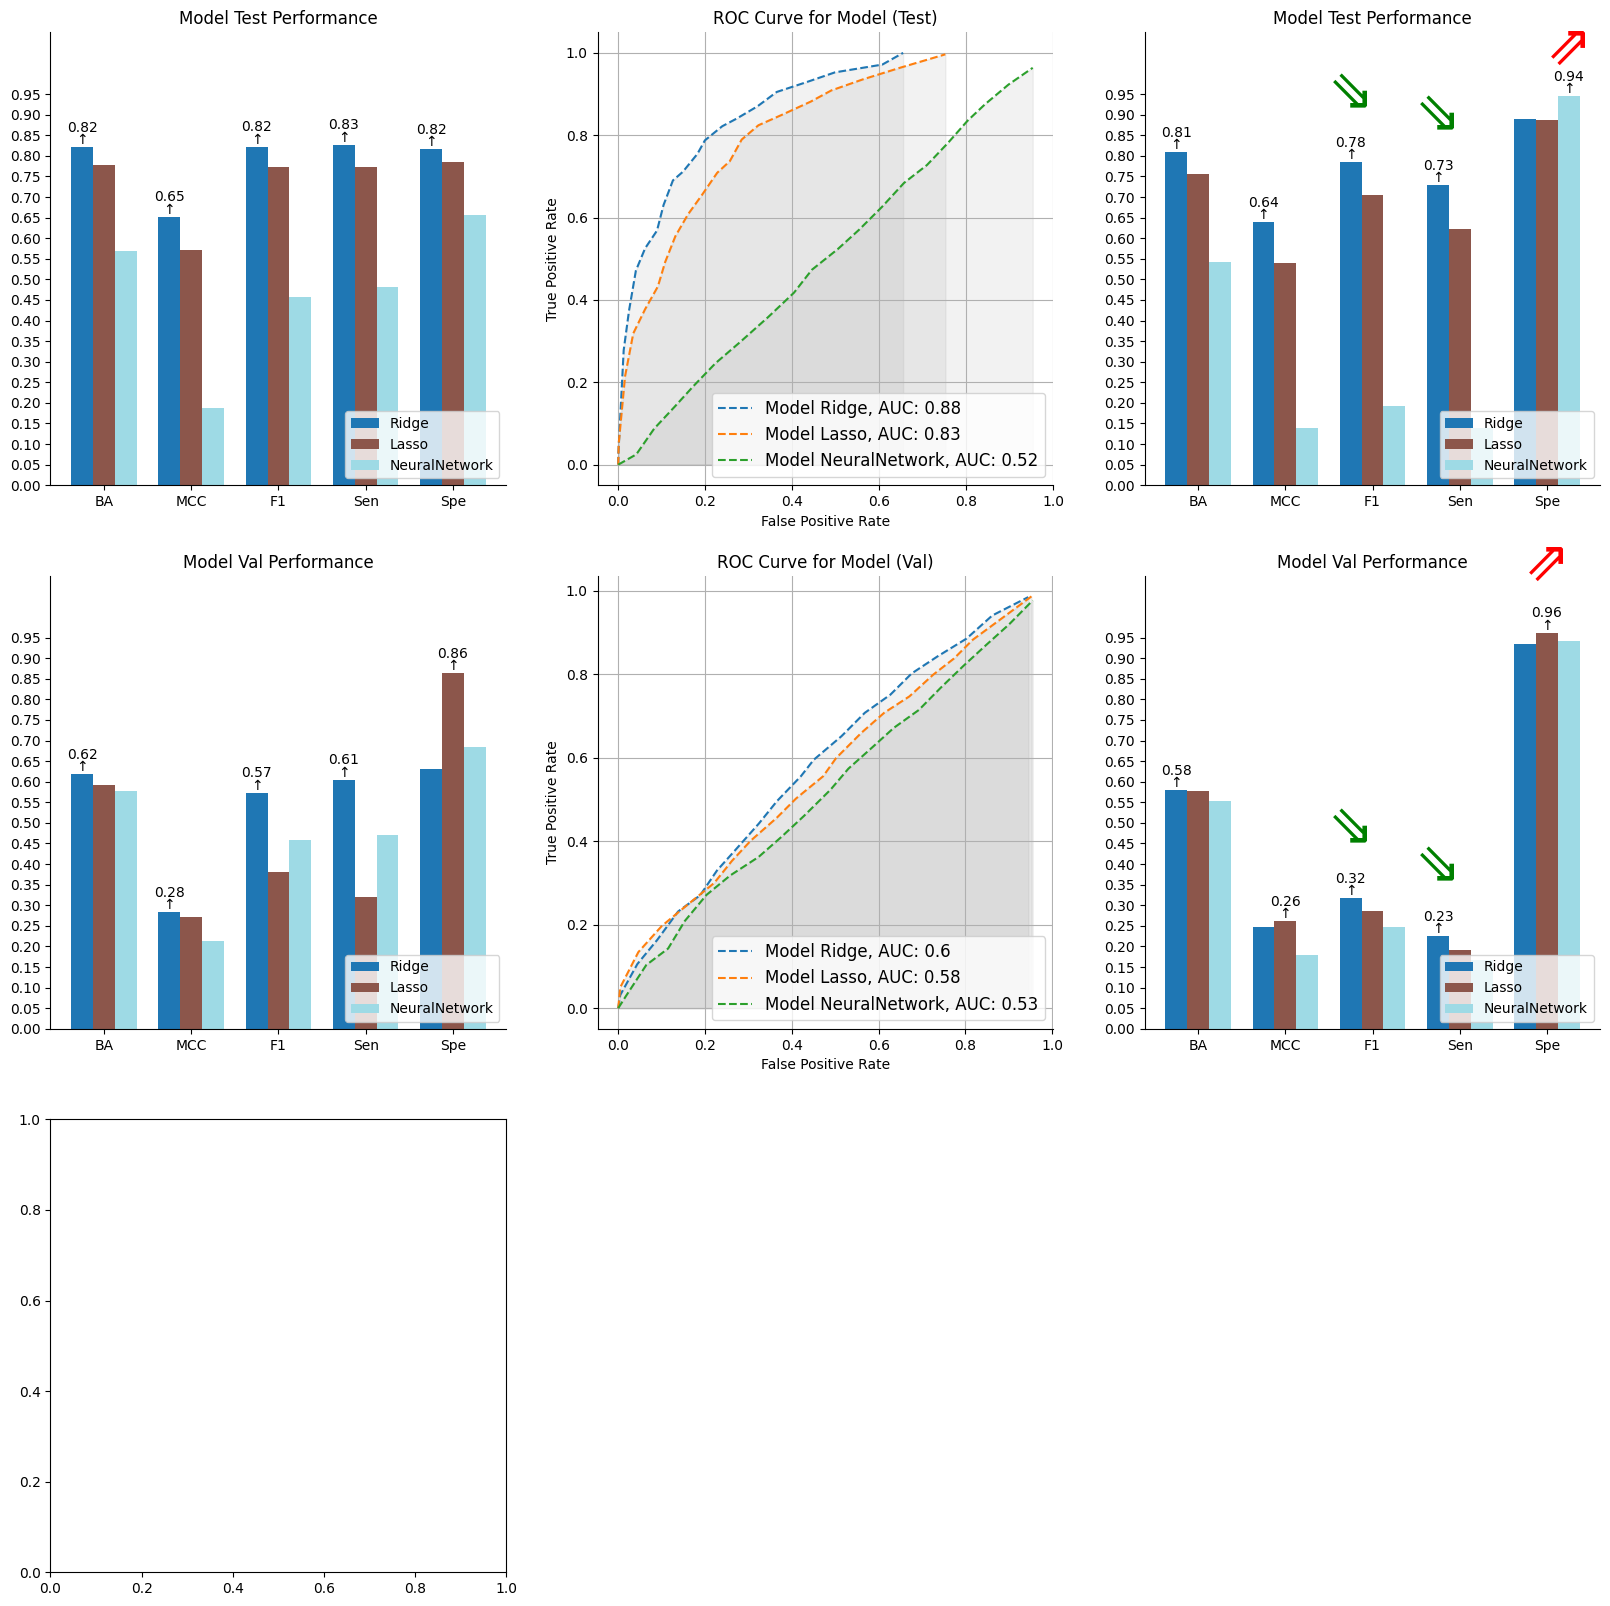

In [51]:
# 2 * 2 subplot
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 1)
# plot 1 bar plot the all metrics for all models, using table 
## different color for different model
## metrics: BA, MCC, F1, Sen, Spe
## metrics as x-axis, value as y-axis
## same metrics no overlap, no gap between them 
## different model with gap between them

x_axis = ['BA', 'MCC', 'F1', 'Sen', 'Spe']
x_axis_loc = np.arange(len(x_axis))

width = 1 / (num_exp + 1)

# more colorful set 
from itertools import cycle
color = cycle(plt.cm.tab20(np.linspace(0, 1, num_exp)))

ba_list = []
mcc_list = []
f1_list = []
sen_list = []
spe_list = []

for i in range(num_exp):
    model = model_list[i]
    
    auc_dic = exp_log[model]['auc_dic'].copy()
    
    remove_key = []
    keys = list(auc_dic.keys())
    for key in keys:
        if type(key) != int:
            # convert to int
            auc_dic[int(key)] = auc_dic[key]
            # delete the original key
            remove_key.append(key)
            
    for key in remove_key:
        auc_dic.pop(key)
        
    ba_list_tmp, mcc_list_tmp, f1_list_tmp, sen_list_tmp, spe_list_tmp = auc_plot(auc_dic, data = 'avg', metric = True)
    
    ba = np.mean(ba_list_tmp)
    mcc = np.mean(mcc_list_tmp)
    f1 = np.mean(f1_list_tmp)
    sen = np.mean(sen_list_tmp)
    spe = np.mean(spe_list_tmp)
    
    ba_list.append(ba)
    mcc_list.append(mcc)
    f1_list.append(f1)
    sen_list.append(sen)
    spe_list.append(spe)

    plt.bar(x_axis_loc + i * width, [ba, mcc, f1, sen, spe], width=width, label=model_short_list[i], color=next(color))
    
# add the value on the top of the bar if the value is highest metric value in that metric
for i, value in enumerate([ba_list, mcc_list, f1_list, sen_list, spe_list]):
    max_value = max(value)
    for j, value in enumerate(value):
        if value == max_value:
            # add a smaill arrow to indicate the highest value
            plt.annotate('↑', (i + j * width, value), ha='center', va='bottom') 
            # add the value on the top of the bar, but move it up a little bit
            plt.text(i + j * width, value + 0.03, round(value, 2), ha='center', va='bottom')
    
plt.xticks(x_axis_loc + width * (num_exp - 1) / 2, x_axis)

plt.legend(loc='lower right')

plt.title('Model Test Performance')

# limit the y-axis to 1.2 
plt.ylim(0, 1.1)

# grid 
# plt.grid()

# remove the top and right line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# change y-axis to 0.05 interval
plt.yticks(np.arange(0, 1., 0.05))

plt.subplot(3, 3, 2)
# plot 2 auc plot for all models 
## different color for different model
## plot the average line for each model

for i in range(num_exp):
    model = model_list[i]
    fpr_avg = [0] * 20
    tpr_avg = [0] * 20
    auc_avg_list = []
    for j in range(50):
        fpr, tpr, _ = roc_curve(exp_log[model]['auc_dic'][str(j)]['avg']['y_test'], exp_log[model]['auc_dic'][str(j)]['avg']['probs'])
        fpr = list(fpr)
        tpr = list(tpr)
        ## proprotionally extend the line to 20 points
        fpr = [fpr[int(i / 20 * len(fpr))] for i in range(20)]
        tpr = [tpr[int(i / 20 * len(tpr))] for i in range(20)]
        tpr_avg = [x + y for x, y in zip(tpr_avg, tpr)]
        fpr_avg = [x + y for x, y in zip(fpr_avg, fpr)]
        
        auc_avg_list.append(roc_auc_score(exp_log[model]['auc_dic'][str(j)]['avg']['y_test'], exp_log[model]['auc_dic'][str(j)]['avg']['probs']))
        
    # average line
    tpr_avg = [x / 50 for x in tpr_avg]
    fpr_avg = [x / 50 for x in fpr_avg]
    
    # calculate auc for average line using tpr_avg_1 and fpr_avg_1
    auc_avg = np.mean(auc_avg_list)
    
    # plot the average line, dashed line
    plt.plot(fpr_avg, tpr_avg, label=f'Model {model}, AUC: {round(auc_avg, 2)}', linestyle='dashed')  
    
    # shade the area between the average line and the x-axis, with grey color
    plt.fill_between(fpr_avg, tpr_avg, 0, alpha=0.1, color='grey')
    

# add grid 
plt.grid()

# remove the top and right line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model (Test)')

# large font size for the legend
plt.legend(fontsize='large')


plt.subplot(3, 3, 3)
# plot 1 bar plot the all metrics for all models, using table 
## different color for different model
## metrics: BA, MCC, F1, Sen, Spe
## metrics as x-axis, value as y-axis
## same metrics no overlap, no gap between them 
## different model with gap between them

x_axis = ['BA', 'MCC', 'F1', 'Sen', 'Spe']
x_axis_loc = np.arange(len(x_axis))

width = 1 / (num_exp + 1)

# more colorful set 
from itertools import cycle
color = cycle(plt.cm.tab20(np.linspace(0, 1, num_exp)))

ba_list = []
mcc_list = []
f1_list = []
sen_list = []
spe_list = []

for i in range(num_exp):
    model = model_list[i]
    
    auc_dic = exp_log[model]['auc_dic'].copy()
    
    remove_key = []
    keys = list(auc_dic.keys())
    for key in keys:
        if type(key) != int:
            # convert to int
            auc_dic[int(key)] = auc_dic[key]
            # delete the original key
            remove_key.append(key)
            
    for key in remove_key:
        auc_dic.pop(key)
        
    ba_list_tmp, mcc_list_tmp, f1_list_tmp, sen_list_tmp, spe_list_tmp = auc_plot(auc_dic, data = 'avg', metric = True, index_independent= 'spe', weight = 0.5)
    
    ba = np.mean(ba_list_tmp)
    mcc = np.mean(mcc_list_tmp)
    f1 = np.mean(f1_list_tmp)
    sen = np.mean(sen_list_tmp)
    spe = np.mean(spe_list_tmp)
    
    ba_list.append(ba)
    mcc_list.append(mcc)
    f1_list.append(f1)
    sen_list.append(sen)
    spe_list.append(spe)

    plt.bar(x_axis_loc + i * width, [ba, mcc, f1, sen, spe], width=width, label=model_short_list[i], color=next(color))
    
# add the value on the top of the bar if the value is highest metric value in that metric
for i, value in enumerate([ba_list, mcc_list, f1_list, sen_list, spe_list]):
    max_value = max(value)
    for j, value in enumerate(value):
        if value == max_value:
            # add a smaill arrow to indicate the highest value
            plt.annotate('↑', (i + j * width, value), ha='center', va='bottom') 
            # add the value on the top of the bar, but move it up a little bit
            plt.text(i + j * width, value + 0.03, round(value, 2), ha='center', va='bottom')
            
            if i == 4:
                # add a arrow to indicate the improvement ⇗, enlarge the font size
                plt.annotate('⇗', (i + j * width, value+0.05), ha='center', va='bottom', fontsize=40, color='red')
                
            if i == 3:
                # add a arrow to indicate the decrease ⇘, enlarge the font size
                plt.annotate('⇘', (i + j * width, value+0.1), ha='center', va='bottom', fontsize=40, color='green')
                
            if i == 2:
                # add a arrow to indicate the decrease ⇘, enlarge the font size
                plt.annotate('⇘', (i + j * width, value+0.1), ha='center', va='bottom', fontsize=40, color='green')
    
plt.xticks(x_axis_loc + width * (num_exp - 1) / 2, x_axis)

plt.legend(loc='lower right')

plt.title('Model Test Performance')

# limit the y-axis to 1.2 
plt.ylim(0, 1.1)

# remove the top and right line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# change y-axis to 0.05 interval
plt.yticks(np.arange(0, 1., 0.05))

plt.subplot(3, 3, 4)
# plot 1 bar plot the all metrics for all models, using table val
## different color for different model
## metrics: BA, MCC, F1, Sen, Spe
## metrics as x-axis, value as y-axis
## same metrics no overlap, no gap between them 
## different model with gap between them

x_axis = ['BA', 'MCC', 'F1', 'Sen', 'Spe']
x_axis_loc = np.arange(len(x_axis))

width = 1 / (num_exp + 1)

# more colorful set 
from itertools import cycle
color = cycle(plt.cm.tab20(np.linspace(0, 1, num_exp)))

ba_list = []
mcc_list = []
f1_list = []
sen_list = []
spe_list = []

num_exp_val = len(exp_log[model_list[0]]['ba_val_avg'])

for i in range(num_exp):
    model = model_list[i]
    auc_dic_val = exp_log[model]['auc_dic_val'].copy()
    
    remove_key = []
    keys = list(auc_dic_val.keys())
    for key in keys:
        if type(key) != int:
            auc_dic_val[int(key)] = auc_dic_val[key]
            remove_key.append(key)
            
    for key in remove_key:
        auc_dic_val.pop(key)
    
    ba_list_tmp, mcc_list_tmp, f1_list_tmp, sen_list_tmp, spe_list_tmp = auc_plot(auc_dic_val, data = 'avg', metric = True)
    
    ba = np.mean(ba_list_tmp)
    mcc = np.mean(mcc_list_tmp)
    f1 = np.mean(f1_list_tmp)
    sen = np.mean(sen_list_tmp)
    spe = np.mean(spe_list_tmp)
    
    ba_list.append(ba)
    mcc_list.append(mcc)
    f1_list.append(f1)
    sen_list.append(sen)
    spe_list.append(spe)

    plt.bar(x_axis_loc + i * width, [ba, mcc, f1, sen, spe], width=width, label=model_short_list[i], color=next(color))
    

# add the value on the top of the bar if the value is highest metric value in that metric
for i, value in enumerate([ba_list, mcc_list, f1_list, sen_list, spe_list]):
    max_value = max(value)
    for j, value in enumerate(value):
        if value == max_value:
            # add a smaill arrow to indicate the highest value
            plt.annotate('↑', (i + j * width, value), ha='center', va='bottom') 
            # add the value on the top of the bar, but move it up a little bit
            plt.text(i + j * width, value + 0.03, round(value, 2), ha='center', va='bottom')
            
plt.xticks(x_axis_loc + width * (num_exp - 1) / 2, x_axis)

plt.legend(loc='lower right')

plt.title('Model Val Performance')

# limit the y-axis to 1.2 
plt.ylim(0, 1.1)

# remove the top and right line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# change y-axis to 0.05 interval
plt.yticks(np.arange(0, 1., 0.05))

plt.subplot(3, 3, 5)
# plot 2 auc plot for all models  val 
## different color for different model
## plot the average line for each model

for i in range(num_exp):
    model = model_list[i]
    fpr_avg = [0] * 20
    tpr_avg = [0] * 20
    auc_avg_list = []
    num_exp_val = len(exp_log[model]['auc_dic_val'])
    for j in range(num_exp_val):
        fpr, tpr, _ = roc_curve(exp_log[model]['auc_dic_val'][str(j)]['avg']['y_test'], exp_log[model]['auc_dic_val'][str(j)]['avg']['probs'])
        fpr = list(fpr)
        tpr = list(tpr)
        ## proprotionally extend the line to 20 points
        fpr = [fpr[int(i / 20 * len(fpr))] for i in range(20)]
        tpr = [tpr[int(i / 20 * len(tpr))] for i in range(20)]
        tpr_avg = [x + y for x, y in zip(tpr_avg, tpr)]
        fpr_avg = [x + y for x, y in zip(fpr_avg, fpr)]
        
        auc_avg_list.append(roc_auc_score(exp_log[model]['auc_dic_val'][str(j)]['avg']['y_test'], exp_log[model]['auc_dic_val'][str(j)]['avg']['probs']))
        
    # average line
    tpr_avg = [x / 50 for x in tpr_avg]
    fpr_avg = [x / 50 for x in fpr_avg]
    
    # calculate auc for average line using tpr_avg_1 and fpr_avg_1
    auc_avg = np.mean(auc_avg_list)
    
    # plot the average line, dashed line
    plt.plot(fpr_avg, tpr_avg, label=f'Model {model}, AUC: {round(auc_avg, 2)}', linestyle='dashed')  
    
    # shade the area between the average line and the x-axis, with grey color
    plt.fill_between(fpr_avg, tpr_avg, 0, alpha=0.1, color='grey')
    
# add grid 
plt.grid()

# remove the
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model (Val)')
plt.legend(fontsize='large')

plt.subplot(3, 3, 6)
# plot 1 bar plot the all metrics for all models, using table val
## different color for different model
## metrics: BA, MCC, F1, Sen, Spe
## metrics as x-axis, value as y-axis
## same metrics no overlap, no gap between them 
## different model with gap between them

x_axis = ['BA', 'MCC', 'F1', 'Sen', 'Spe']
x_axis_loc = np.arange(len(x_axis))

width = 1 / (num_exp + 1)

# more colorful set 
from itertools import cycle
color = cycle(plt.cm.tab20(np.linspace(0, 1, num_exp)))

ba_list = []
mcc_list = []
f1_list = []
sen_list = []
spe_list = []

num_exp_val = len(exp_log[model_list[0]]['ba_val_avg'])

for i in range(num_exp):
    model = model_list[i]
    auc_dic_val = exp_log[model]['auc_dic_val'].copy()
    
    remove_key = []
    keys = list(auc_dic_val.keys())
    for key in keys:
        if type(key) != int:
            auc_dic_val[int(key)] = auc_dic_val[key]
            remove_key.append(key)
            
    for key in remove_key:
        auc_dic_val.pop(key)
    
    ba_list_tmp, mcc_list_tmp, f1_list_tmp, sen_list_tmp, spe_list_tmp = auc_plot(auc_dic_val, data = 'avg', metric = True, index_independent= 'spe', weight = 0.3)
    
    ba = np.mean(ba_list_tmp)
    mcc = np.mean(mcc_list_tmp)
    f1 = np.mean(f1_list_tmp)
    sen = np.mean(sen_list_tmp)
    spe = np.mean(spe_list_tmp)
    
    ba_list.append(ba)
    mcc_list.append(mcc)
    f1_list.append(f1)
    sen_list.append(sen)
    spe_list.append(spe)

    plt.bar(x_axis_loc + i * width, [ba, mcc, f1, sen, spe], width=width, label=model_short_list[i], color=next(color))
    

# add the value on the top of the bar if the value is highest metric value in that metric
for i, value in enumerate([ba_list, mcc_list, f1_list, sen_list, spe_list]):
    max_value = max(value)
    for j, value in enumerate(value):
        if value == max_value:
            # add a smaill arrow to indicate the highest value
            plt.annotate('↑', (i + j * width, value), ha='center', va='bottom') 
            # add the value on the top of the bar, but move it up a little bit
            plt.text(i + j * width, value + 0.03, round(value, 2), ha='center', va='bottom')
            
            if i == 4:
                # add a arrow to indicate the improvement ⇗, enlarge the font size
                plt.annotate('⇗', (i + j * width, value+0.1), ha='center', va='bottom', fontsize=40, color='red')
                
            if i == 3:
                # add a arrow to indicate the decrease ⇘, enlarge the font size
                plt.annotate('⇘', (i + j * width, value+0.1), ha='center', va='bottom', fontsize=40, color='green')
                
            if i == 2:
                # add a arrow to indicate the decrease ⇘, enlarge the font size
                plt.annotate('⇘', (i + j * width, value+0.1), ha='center', va='bottom', fontsize=40, color='green')
            
            
plt.xticks(x_axis_loc + width * (num_exp - 1) / 2, x_axis)

plt.legend(loc='lower right')

plt.title('Model Val Performance')

# limit the y-axis to 1.2 
plt.ylim(0, 1.1)

# remove the top and right line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# change y-axis to 0.05 interval
plt.yticks(np.arange(0, 1., 0.05))
    
plt.subplot(3, 3, 7)
# plot 3 importance analysis rank for top overlap features
# select the top 20 features by rank
n = 20
color = cycle(plt.cm.tab20(np.linspace(0, 1, num_exp)))

# width thin 
plt.barh([x for x in feature_list_top[:n]], [importance_analysis_avg_common['LogisticRegression'][x]['rank_avg'] for x in feature_list_top[:n]], color= 'orange', height=0.2)

# remove the top and right line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# empty x-axis label
plt.xticks([])
plt.xlabel('Importance Relative Rank')

# change y-axis position 
plt.yticks(np.arange(n), feature_list_top[:n])

# add the horizontal line for each feature, indicating the rank of the feature in different models 
for i in range(n):
    plt.axhline(y=i, color='grey', linestyle='dotted')

plt.title(f'Model Importance Analysis by Rank for Top {n} Features')

plt.subplot(3, 3, 8)
# violin plot for the top 20 features by value, moving down, matching the height of the bar plot
plt.violinplot([importance_analysis_avg_common['LogisticRegression'][x]['value'] for x in feature_list_top[:n]], vert=False, positions=np.arange(n), showmeans=False, showmedians=True)

# red point for the average value of the feature
plt.scatter([importance_analysis_avg_common['LogisticRegression'][x]['value_avg'] for x in feature_list_top[:n]], np.arange(n), color='red', label='average value')

# vertical line at 0
plt.axvline(x=0, color='grey', linestyle='--')

# change y-axis position 
plt.yticks(np.arange(n), [])

# remove the top and right line, left line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.legend()
plt.xlabel('Importance Value')

plt.title(f'Model Importance Analysis by Value for Top {n} Features')


# add dashed horizontal line for each feature, indicating the rank of the feature in different models 
# between the violin plot and the bar plot
for i in range(n):
    plt.axhline(y=i, color='grey', linestyle='dotted')

# save the figure
plt.savefig(f'RIF/result/{version}_model_performance.png')

# correlation with time interval

In [ ]:
# inverse transform the data
if X.shape[1] < 500:
    X = pca.inverse_transform(X)

data_tmp = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)

In [ ]:
col_name = data_train_copy.columns
col_name = list(col_name[:-1])
col_name.append('interval_from_ert_to_transfer')

In [ ]:
# data/data_processed/RIF_n311_m40599_0817.csv
data = pd.read_csv('data/data_processed/RIF_n311_m40599_0817.csv')


移植日期 = data['移植日期']

# convert to datetime
移植日期 = pd.to_datetime(移植日期, format='%Y-%m-%d %H:%M:%S')

检测日期 = data['检测流水号']
检测日期 = 检测日期.str.split('_').str[2]
检测日期 = ['20' + i for i in 检测日期]

# convert to datetime
检测日期 = pd.to_datetime(检测日期, format='%Y%m%d')

data['interval_from_ert_to_transfer'] = (移植日期 - 检测日期).dt.days

In [ ]:
data_copy = data.copy()
data_train_copy_tmp = data_train_copy.copy()
data_tmp_copy = data_tmp.copy()

In [ ]:
data_copy = data_copy[col_name]

KeyError: "['SCPPPQ1', 'NICOL1', 'RPL34P24', 'ZNF217-AS1', 'JUN-DT', 'GRHL2-DT', 'LITATS1', 'RGL4P1', 'LY6S-AS1', 'IDH1P1', 'Unnamed: 0', 'MTCL2', 'RPS3P4', 'FTLP20', 'VCF2', 'ARB2BP', 'SNX7-DT', 'PARAIL'] not in index"

In [ ]:
data_train_copy_tmp['interval_from_ert_to_transfer'] = None

In [ ]:
tmp_list = []

col_name_tmp = col_name.copy()
col_name_tmp.remove('interval_from_ert_to_transfer')

# random select 200 features
import random
index_random = random.sample(range(len(col_name_tmp)), 200)
col_name_tmp = [col_name_tmp[i] for i in index_random]

# add the interval_from_ert_to_transfer to the data
col_name_tmp.append('interval_from_ert_to_transfer')

data_copy = data_copy[col_name_tmp]
data_train_copy_tmp = data_train_copy_tmp[col_name_tmp]

col_name = col_name_tmp

col_name_tmp = col_name.copy()
col_name_tmp.remove('interval_from_ert_to_transfer')

In [ ]:
for i in tqdm(range(len(data_train_copy_tmp))):
    data_i = data_train_copy_tmp.iloc[i].copy()
    data_i = list(data_i[col_name_tmp])
    
    for j in range(len(data_copy)):
        data_j = data_copy.iloc[j].copy()
        data_j =list(data_j[col_name_tmp])
        
        if data_i == data_j:
            tmp_list.append(data_copy.iloc[j]['interval_from_ert_to_transfer'])
            break
        
# check if the length is the same
len(tmp_list) == len(data_train_copy)

100%|██████████| 261/261 [00:08<00:00, 30.67it/s] 


True

In [ ]:
data_train_copy_tmp['interval_from_ert_to_transfer'] = tmp_list

In [ ]:
# add label target to data_train_copy_tmp
data_train_copy_tmp['label'] = data_tmp_copy[target]

In [ ]:
# save the data_train
data_train_copy_tmp.to_csv('data/data_processed/data_train_copy_tmp.csv', index=False)

In [ ]:
# load the data_train_copy_tmp
data_train_copy_tmp = pd.read_csv('data/data_processed/data_train_copy_tmp.csv')

In [ ]:
len(col_name_tmp) == len(index_random)

True

In [ ]:
probs_list = [0] * len(data_train_copy_tmp)
count_list = [0] * len(data_train_copy_tmp) 

In [ ]:
for i in range(num_exp):
    model = model_list[i]
    model_name = model_short_list[i]
    # round to 2 decimal
    auc_dic = exp_log[model]['auc_dic'].copy()
    
    num_experiment = len(auc_dic)
    
    for j in tqdm(range(num_experiment)):
        X_test_list = auc_dic[str(j)]['avg']['X_test']
        # create pd, with len(X_test_list) rows and len(X_test_list[0]) columns
        X_test = pd.DataFrame(X_test_list)
        
        X_test_inverse = pd.DataFrame(pca.inverse_transform(X_test))
        
        # select the columns that are in col_name_tmp
        X_test_inverse = X_test_inverse.iloc[:, index_random]
        
        # change the column name to col_name_tmp
        X_test_inverse.columns = col_name_tmp
        
        # get probs 
        probs = auc_dic[str(j)]['avg']['probs']
        
        min_index_list = []
        
        for k in range(len(X_test_inverse)):
            data_i = X_test_inverse.iloc[k].copy()
            data_i = list(data_i)
            sum_difference_list = np.sum(abs(data_train_copy_tmp.iloc[:,:-2] - data_i), axis=1)
            
            # get the index of the minimum value
            min_index = np.argmin(sum_difference_list)
            
            min_index_list.append(min_index)
            
        # add probs to probs_list according to the min_index_list
        for k in range(len(min_index_list)):
            probs_list[min_index_list[k]] += probs[k]
            count_list[min_index_list[k]] += 1

100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


In [ ]:
for i in range(len(probs_list)):
    probs_list[i] /= count_list[i]

In [ ]:
# update the data_train_copy_tmp with the probs_list
data_train_copy_tmp['probs'] = probs_list

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


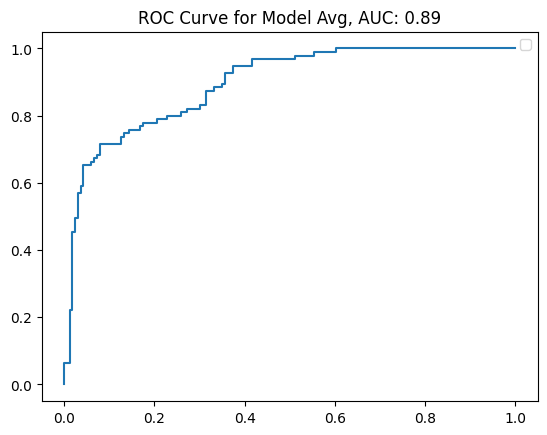

In [ ]:
label = data_train_copy_tmp['label']
probs = data_train_copy_tmp['probs']
auc_score = roc_auc_score(label, probs)
fpr, tpr, _ = roc_curve(label, probs, pos_label=1)
# add the auc score to the title
plt.title(f'ROC Curve for Model Avg, AUC: {round(auc_score, 2)}')

plt.legend()

plt.plot(fpr, tpr)

In [ ]:
# differece between the two label and probs
diff = abs(label - probs)  

In [ ]:
# corralation between the difference and the interval_from_ert_to_transfer
np.corrcoef(diff, data_train_copy_tmp['interval_from_ert_to_transfer'])[0][1]

-0.021221766737585922

<Figure size 1500x500 with 0 Axes>

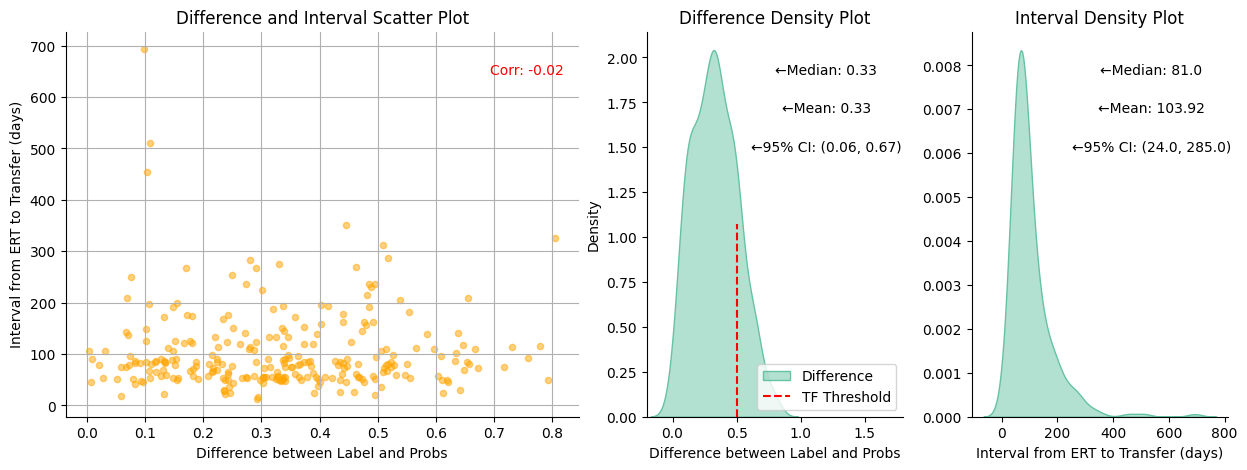

<Figure size 640x480 with 0 Axes>

In [ ]:
# distribution of the difference and the interval_from_ert_to_transfer

plt.figure(figsize=(15, 5))

# subplot 1
# set subplot size
fig, ax = plt.subplots(1,3, figsize=(15, 5),gridspec_kw={'width_ratios': [2,1,1]})

# plot the scatter plot for the difference and the interval_from_ert_to_transfer
ax[0].scatter(diff, data_train_copy_tmp['interval_from_ert_to_transfer'], alpha=0.5, s=20, color='orange')
ax[0].set_xlabel('Difference between Label and Probs')
ax[0].set_ylabel('Interval from ERT to Transfer (days)')
ax[0].set_title('Difference and Interval Scatter Plot')

# remove the top and right line
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# add corrcoef to the plot 
corr = np.corrcoef(diff, data_train_copy_tmp['interval_from_ert_to_transfer'])[0][1]
ax[0].annotate(f'Corr: {round(corr, 2)}', (0.9, 0.9), xycoords='axes fraction', ha='center', va='center', color='red')

# add grid 
ax[0].grid()

# subplot 2
# density plot for the difference
# add density line for the difference, with shade area under the line
sns.color_palette("Set2")
density_list = sns.kdeplot(diff,label='Difference', alpha=0.5, ax=ax[1], color=sns.color_palette("Set2")[0], fill = True)

ax[1].set_xlabel('Difference between Label and Probs')
ax[1].set_ylabel('Density')
ax[1].set_title('Difference Density Plot')

# remove the top and right line
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# add median and mean, 95% confidence interval lower and upper bound to the plot
median = np.median(diff)
mean = np.mean(diff)
lower = np.percentile(diff, 2.5)
upper = np.percentile(diff, 97.5)

ax[1].annotate(f'←Median: {round(median, 2)}', (0.7, 0.9), xycoords='axes fraction', ha='center', va='center', color='black')
ax[1].annotate(f'←Mean: {round(mean, 2)}', (0.7, 0.8), xycoords='axes fraction', ha='center', va='center', color='black')
ax[1].annotate(f'←95% CI: ({round(lower, 2)}, {round(upper, 2)})', (0.7, 0.7), xycoords='axes fraction', ha='center', va='center', color='black')

# x-axis limit
ax[1].set_xlim([-.2, 1.8])

# add vertical line for x = 0.5, y from 0 to 1 
ax[1].axvline(x=0.5, ymin=0, ymax=0.5, color='red', linestyle='dashed', label='TF Threshold')

# add the legend
ax[1].legend(loc = 'lower right')

# add grid 
# ax[1].grid()

# subplot 3
# density plot for the interval_from_ert_to_transfer
# add density line for the interval_from_ert_to_transfer, with shade area under the line, dashed line
density_list = sns.kdeplot(data_train_copy_tmp['interval_from_ert_to_transfer'],label='Interval', alpha=0.5, ax=ax[2], color=sns.color_palette("Set2")[0], fill = True)
ax[2].set_xlabel('Interval from ERT to Transfer (days)')
ax[2].set_ylabel('')
ax[2].set_title('Interval Density Plot')

# add median and mean, 95% confidence interval lower and upper bound to the plot
median = np.median(data_train_copy_tmp['interval_from_ert_to_transfer'])
mean = np.mean(data_train_copy_tmp['interval_from_ert_to_transfer'])
lower = np.percentile(data_train_copy_tmp['interval_from_ert_to_transfer'], 2.5)
upper = np.percentile(data_train_copy_tmp['interval_from_ert_to_transfer'], 97.5)

ax[2].annotate(f'←Median: {round(median, 2)}', (0.7, 0.9), xycoords='axes fraction', ha='center', va='center', color='black')
ax[2].annotate(f'←Mean: {round(mean, 2)}', (0.7, 0.8), xycoords='axes fraction', ha='center', va='center', color='black')
ax[2].annotate(f'←95% CI: ({round(lower, 2)}, {round(upper, 2)})', (0.7, 0.7), xycoords='axes fraction', ha='center', va='center', color='black')


# remove the top and right line
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)

# add grid 
# ax[2].grid()

# show 
plt.show()

# save the figure
plt.savefig(f'RIF/result/{version}_difference_interval.png', dpi=300)

# X